# Laboratorio Número 2 - Regresión

El objetivo de este notebook es construir un modelo analítico para estimar el número de muertes por cáncer por cada 100.000 habitantes a partir de un conjunto de variables observadas. Este modelo no solo debe abordar la tarea de regresión, sino también la automatización mediante pipelines para su implementación en entornos de producción. El objetivo final es extraer información relevante para el negocio a partir de los resultados obtenidos, permitiendo a la Organización Mundial de la Salud y a los gobiernos locales identificar poblaciones vulnerables y asignar recursos de manera eficiente para programas de diagnóstico temprano, tratamiento y financiamiento de la investigación en cáncer. 

 ##### **1. Carga de datos**

In [55]:
import numpy as np
import pandas as pd
import math

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.base import BaseEstimator, TransformerMixin

import scipy.stats as stats

In [56]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

In [57]:
train_data = pd.read_csv("../data/train_data.csv")
val_data = pd.read_csv("../data/val_data.csv")

In [58]:
train_data.shape, val_data.shape

((2132, 34), (915, 33))

In [59]:
extra_columns_train = set(train_data.columns) - set(val_data.columns)
extra_columns_train

{'deathRate'}

In [60]:
train_data.dtypes

avgAnnCount                float64
avgDeathsPerYear             int64
incidenceRate              float64
medIncome                    int64
popEst2015                   int64
povertyPercent             float64
studyPerCap                float64
binnedInc                   object
MedianAge                  float64
MedianAgeMale              float64
MedianAgeFemale            float64
Geography                   object
AvgHouseholdSize           float64
PercentMarried             float64
PctNoHS18_24               float64
PctHS18_24                 float64
PctSomeCol18_24            float64
PctBachDeg18_24            float64
PctHS25_Over               float64
PctBachDeg25_Over          float64
PctEmployed16_Over         float64
PctUnemployed16_Over       float64
PctPrivateCoverage         float64
PctPrivateCoverageAlone    float64
PctEmpPrivCoverage         float64
PctPublicCoverage          float64
PctPublicCoverageAlone     float64
PctWhite                   float64
PctBlack            

In [61]:
val_data.dtypes

avgAnnCount                float64
avgDeathsPerYear             int64
incidenceRate              float64
medIncome                    int64
popEst2015                   int64
povertyPercent             float64
studyPerCap                float64
binnedInc                   object
MedianAge                  float64
MedianAgeMale              float64
MedianAgeFemale            float64
Geography                   object
AvgHouseholdSize           float64
PercentMarried             float64
PctNoHS18_24               float64
PctHS18_24                 float64
PctSomeCol18_24            float64
PctBachDeg18_24            float64
PctHS25_Over               float64
PctBachDeg25_Over          float64
PctEmployed16_Over         float64
PctUnemployed16_Over       float64
PctPrivateCoverage         float64
PctPrivateCoverageAlone    float64
PctEmpPrivCoverage         float64
PctPublicCoverage          float64
PctPublicCoverageAlone     float64
PctWhite                   float64
PctBlack            

In [62]:
train_data.sample(5)

avgAnnCount  avgDeathsPerYear  incidenceRate  medIncome  popEst2015  \
648        1757.0               561          469.0      57908      434211   
1011        155.0                63          457.3      30636       26395   
332         554.0               196          500.8      49781      117635   
105         177.0                69          435.2      41035       29991   
469         126.0                42          526.7      51550       25490   

      povertyPercent  studyPerCap           binnedInc  MedianAge  \
648             11.6   414.545002  (54545.6, 61494.5]       35.8   
1011            29.4    37.885963    [22640, 34218.1]       39.3   
332             15.1     0.000000  (48021.6, 51046.4]       31.8   
105             15.8     0.000000  (40362.7, 42724.4]       44.9   
469             20.5     0.000000  (51046.4, 54545.6]       35.4   

      MedianAgeMale  MedianAgeFemale                           Geography  \
648            35.0             36.6                   Ada County, Idaho   
1011           37.2             41.1         Morehouse Parish, Louisiana   
332            30.5             33.6          Jefferson County, New York   
105            44.1             45.6              Franklin County, Maine   
469            34.6             36.7  West Baton Rouge Parish, Louisiana   

      AvgHouseholdSize  PercentMarried  PctNoHS18_24  PctHS18_24  \
648             2.6100            53.6          10.4        30.1   
1011            2.5000            42.9          30.7        38.5   
332             2.5400            53.5           8.1        44.2   
105             0.0248            51.3          10.2        30.4   
469             2.6100            47.1          18.4        35.9   

      PctSomeCol18_24  PctBachDeg18_24  PctHS25_Over  PctBachDeg25_Over  \
648              48.1             11.4          21.4               24.8   
1011              NaN              1.8          43.5                9.3   
332               NaN              5.7          33.5               11.8   
105               NaN              5.3          36.9               16.4   
469               NaN              5.7          39.2               14.1   

      PctEmployed16_Over  PctUnemployed16_Over  PctPrivateCoverage  \
648                 61.9                   6.6                76.1   
1011                47.0                   8.0                46.9   
332                 48.6                  10.6                69.7   
105                 56.7                   7.7                63.4   
469                 61.0                   6.5                68.1   

      PctPrivateCoverageAlone  PctEmpPrivCoverage  PctPublicCoverage  \
648                       NaN                53.6               23.7   
1011                     34.7                30.4               45.3   
332                      52.3                34.5               36.4   
105                       NaN                40.5               42.0   
469                       NaN                50.1               30.0   

      PctPublicCoverageAlone   PctWhite   PctBlack  PctAsian  PctOtherRace  \
648                     11.1  91.402416   1.135566  2.665143      1.284308   
1011                    30.3  50.407226  47.290093  0.255442      0.636754   
332                     19.8  86.393099   5.525991  1.450226      1.668810   
105                     21.1  97.029801   0.440760  0.470364      0.171041   
469                     17.1  59.751105  37.812639  0.571568      0.575621   

      PctMarriedHouseholds  BirthRate  deathRate  
648              52.607352   4.783516      151.6  
1011             42.031205   4.979184      186.4  
332              52.372139   7.816391      177.0  
105              52.419559   3.482222      167.5  
469              47.020373   5.538105      182.8

In [63]:
val_data.sample(5)

avgAnnCount  avgDeathsPerYear  incidenceRate  medIncome  popEst2015  \
206        212.0                91          429.9      53211       42461   
768         92.0                36          489.7      40422       12529   
228         49.0                23          552.9      37061        7131   
514         84.0                32          400.2      48006       21482   
84         947.0               362          504.8      41783      200579   

     povertyPercent  studyPerCap           binnedInc  MedianAge  \
206             8.0     0.000000  (51046.4, 54545.6]       41.2   
768            17.5     0.000000  (40362.7, 42724.4]       44.7   
228            19.4     0.000000  (34218.1, 37413.8]      501.6   
514            14.3     0.000000    (45201, 48021.6]       34.0   
84             21.9   174.494837  (40362.7, 42724.4]       33.5   

     MedianAgeMale  MedianAgeFemale                  Geography  \
206           40.0             42.3     Dubois County, Indiana   
768           43.9             46.7     Appanoose County, Iowa   
228           39.9             43.3  Nicholas County, Kentucky   
514           33.1             35.0  Colusa County, California   
84            31.5             35.5   Muscogee County, Georgia   

     AvgHouseholdSize  PercentMarried  PctNoHS18_24  PctHS18_24  \
206              2.55            58.4          14.8        32.7   
768              2.28            56.2          21.6        28.6   
228              2.47            54.6          21.9        41.9   
514              3.04            55.1          14.2        41.9   
84               2.61            39.5          12.5        32.3   

     PctSomeCol18_24  PctBachDeg18_24  PctHS25_Over  PctBachDeg25_Over  \
206              NaN             11.6          41.9               12.9   
768              NaN              6.3          36.3               12.9   
228              NaN              0.0          40.7                6.0   
514              NaN              2.7          21.7               11.4   
84              48.8              6.4          27.7               15.0   

     PctEmployed16_Over  PctUnemployed16_Over  PctPrivateCoverage  \
206                65.7                   3.3                78.8   
768                57.1                   6.6                65.2   
228                51.0                   7.7                55.3   
514                55.3                  10.4                48.9   
84                 50.2                  11.0                62.4   

     PctPrivateCoverageAlone  PctEmpPrivCoverage  PctPublicCoverage  \
206                     64.9                60.7               24.8   
768                     47.3                39.5               40.4   
228                     40.2                34.8               42.4   
514                      NaN                29.6               42.3   
84                      46.4                32.3               34.9   

     PctPublicCoverageAlone   PctWhite   PctBlack  PctAsian  PctOtherRace  \
206                    12.4  95.339434   0.387789  0.645527      2.913149   
768                    19.4  97.458363   0.339411  0.370984      0.102613   
228                    25.4  96.918728   1.469965  0.000000      0.098940   
514                    30.9  85.006543   0.705739  1.958310      7.613573   
84                     19.3  45.818209  44.767706  2.407569      2.719625   

     PctMarriedHouseholds  BirthRate  
206             59.085855   6.889677  
768             50.538223   5.490037  
228             53.151558   4.939064  
514             57.565317   6.602564  
84              39.015943   6.992368

##### **2. Entendimiento de datos**

In [64]:
train_data.describe()

avgAnnCount  avgDeathsPerYear  incidenceRate      medIncome  \
count   2132.000000       2132.000000    2132.000000    2132.000000   
mean     613.385785        183.537992     448.816467   47029.474203   
std     1435.393846        507.649052      53.582307   12107.930677   
min        6.000000          3.000000     201.300000   22640.000000   
25%       77.000000         28.000000     421.600000   38875.750000   
50%      174.500000         62.000000     453.549422   45207.000000   
75%      515.250000        141.000000     481.600000   52376.250000   
max    38150.000000      14010.000000    1014.200000  125635.000000   

         popEst2015  povertyPercent  studyPerCap    MedianAge  MedianAgeMale  \
count  2.132000e+03     2132.000000  2132.000000  2132.000000    2132.000000   
mean   1.025064e+05       16.889681   158.003002    44.298687      39.559475   
std    3.442282e+05        6.415614   533.636824    39.522898       5.208212   
min    8.290000e+02        3.200000     0.000000    23.500000      22.800000   
25%    1.154725e+04       12.200000     0.000000    37.700000      36.300000   
50%    2.693200e+04       15.900000     0.000000    40.900000      39.600000   
75%    6.663525e+04       20.300000    79.275307    44.000000      42.600000   
max    1.017029e+07       47.400000  9439.200444   619.200000      64.700000   

       MedianAgeFemale  AvgHouseholdSize  PercentMarried  PctNoHS18_24  \
count      2132.000000       2132.000000     2132.000000   2132.000000   
mean         42.140009          2.479013       51.756285     18.134897   
std           5.272267          0.421538        6.925242      8.091987   
min          22.800000          0.022100       23.100000      0.000000   
25%          39.000000          2.360000       47.775000     12.700000   
50%          42.300000          2.500000       52.300000     17.100000   
75%          45.400000          2.630000       56.500000     22.425000   
max          65.700000          3.970000       72.500000     64.100000   

        PctHS18_24  PctSomeCol18_24  PctBachDeg18_24  PctHS25_Over  \
count  2132.000000       528.000000      2132.000000   2132.000000   
mean     34.981660        41.151705         6.201173     34.949578   
std       9.024105        11.046405         4.628540      7.056699   
min       0.000000         7.100000         0.000000      7.500000   
25%      29.200000        34.000000         3.100000     30.600000   
50%      34.700000        40.600000         5.400000     35.400000   
75%      40.700000        46.725000         8.300000     39.800000   
max      65.700000        79.000000        51.800000     54.800000   

       PctBachDeg25_Over  PctEmployed16_Over  PctUnemployed16_Over  \
count        2132.000000         2017.000000           2132.000000   
mean           13.225797           54.119137              7.843574   
std             5.395211            8.398898              3.448596   
min             2.500000           17.600000              0.700000   
25%             9.300000           48.600000              5.500000   
50%            12.300000           54.400000              7.600000   
75%            16.100000           60.300000              9.700000   
max            42.200000           80.100000             29.400000   

       PctPrivateCoverage  PctPrivateCoverageAlone  PctEmpPrivCoverage  \
count         2132.000000              1704.000000         2132.000000   
mean            64.393011                48.407688           41.237899   
std             10.670887                 9.985504            9.326155   
min             22.300000                15.700000           13.500000   
25%             57.175000                41.275000           34.600000   
50%             65.300000                48.800000           41.300000   
75%             72.100000                55.500000           47.600000   
max             92.300000                78.200000           70.700000   

       PctPublicCoverage  PctPublicCoverageAlone   

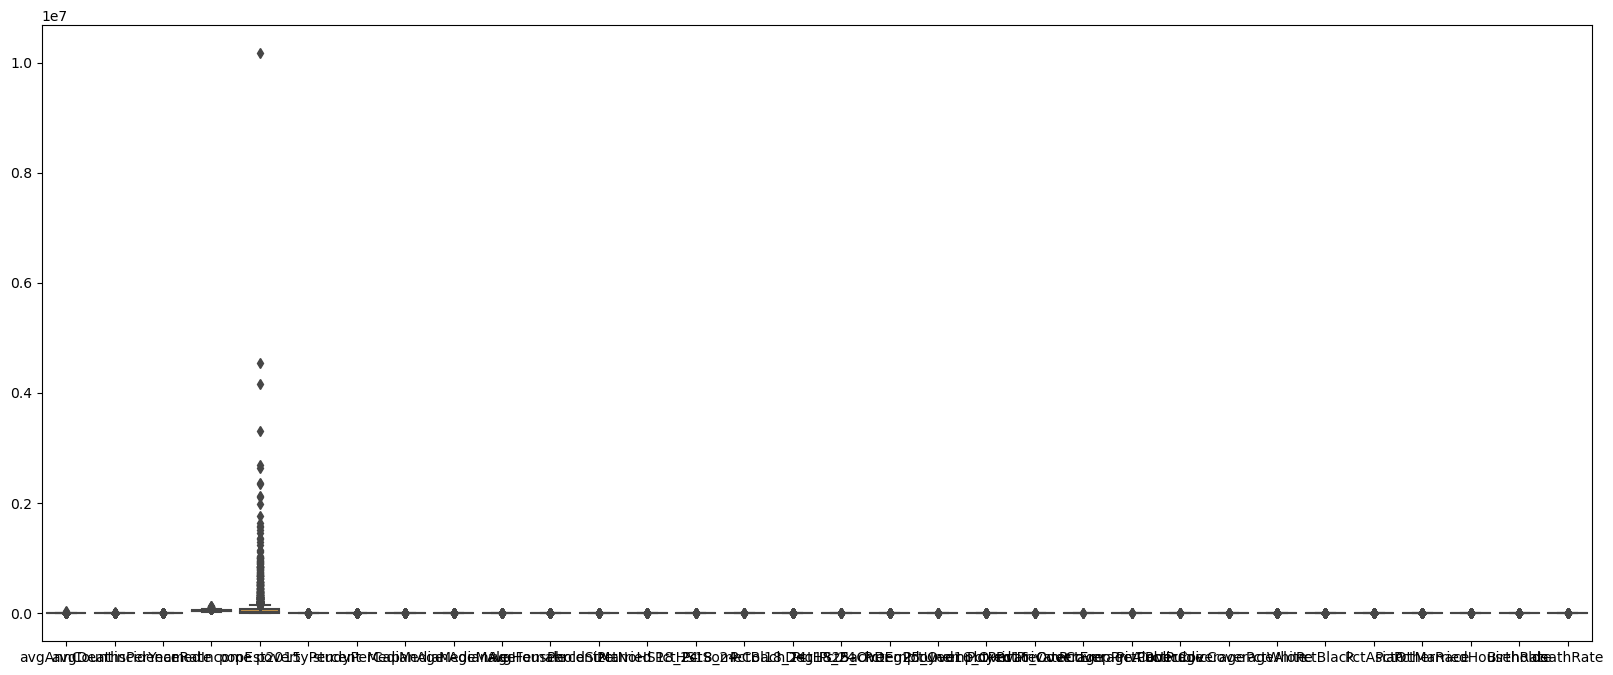

In [65]:
fig = plt.figure(figsize=(20,8))
ax = sns.boxplot(data=train_data, orient="v")

In [66]:
# Inicialmente identificamos a las columnas que sean de tipo object para ver si podemos convertirlas a numéricas
train_data.select_dtypes(include=["object"]).head()

binnedInc                     Geography
0  (34218.1, 37413.8]  Gregory County, South Dakota
1  (48021.6, 51046.4]      Taylor County, Wisconsin
2  (54545.6, 61494.5]   Bowman County, North Dakota
3    [22640, 34218.1]       Quitman County, Georgia
4  (37413.8, 40362.7]          Owyhee County, Idaho

In [67]:
"""
Luego nos damos cuenta que binnedInc hace referencia al ingreso mediano per capita (clasificado por decil), por lo cual podriamos tomar las siguientes decisiones:

1. Convertir las categorias a valores numéricos, por ejemplo, 1-10 -> 5.5
2. Mantener una columna para el rango inferior y otra para el rango superior

Antes de decidir vamos a ver diferencia entre los valores de binnedInc, para ver si es significativa
binnedInc	Geography
0	(34218.1, 37413.8]	Gregory County, South Dakota
1	(48021.6, 51046.4]	Taylor County, Wisconsin
2	(54545.6, 61494.5]	Bowman County, North Dakota
3	[22640, 34218.1]	Quitman County, Georgia
4	(37413.8, 40362.7]	Owyhee County, Idaho
"""

# Obtener parejas de valores únicos de binnedInc en una lista para visualizarlas de la siguiente forma: pairs = [(a,b),(c.d),...]
pairs = train_data["binnedInc"].unique()
for i in range(len(pairs)):
    pairs[i] = pairs[i].strip("[]()").split(", ")
    pairs[i] = (float(pairs[i][0]), float(pairs[i][1]))
print("\nPairs:")
print(pairs[0])
print(pairs)
print("\n")

# Value counts de binnedInc
print(f"Unique values from original data:\n{train_data['binnedInc'].unique()}\n")
print(f"Len of uniques: {len(train_data['binnedInc'].unique())}\nLen of pairs: {len(pairs)}\n")

# Diferencia promedio entre los valores de binnedInc, diferencia maxima y minima, y desviacion estandar
diffs = [abs(pair[1] - pair[0]) for pair in pairs]
print(f"Mean difference between pairs: {np.mean(diffs)}")
print(f"Max difference between pairs: {np.max(diffs)}\nPair with max difference: {pairs[np.argmax(diffs)]}")
print(f"Min difference between pairs: {np.min(diffs)}")
print(f"Standard deviation of differences: {np.std(diffs)}")




Pairs:
(34218.1, 37413.8)
[(34218.1, 37413.8) (48021.6, 51046.4) (54545.6, 61494.5)
 (22640.0, 34218.1) (37413.8, 40362.7) (40362.7, 42724.4)
 (51046.4, 54545.6) (61494.5, 125635.0) (42724.4, 45201.0)
 (45201.0, 48021.6)]


Unique values from original data:
['(34218.1, 37413.8]' '(48021.6, 51046.4]' '(54545.6, 61494.5]'
 '[22640, 34218.1]' '(37413.8, 40362.7]' '(40362.7, 42724.4]'
 '(51046.4, 54545.6]' '(61494.5, 125635]' '(42724.4, 45201]'
 '(45201, 48021.6]']

Len of uniques: 10
Len of pairs: 10

Mean difference between pairs: 10299.5
Max difference between pairs: 64140.5
Pair with max difference: (61494.5, 125635.0)
Min difference between pairs: 2361.7000000000044
Standard deviation of differences: 18153.555113971477


In [68]:
""" 
Mean difference between pairs: 10299.5
Max difference between pairs: 64140.5
Pair with max difference: (61494.5, 125635.0)
Min difference between pairs: 2361.7000000000044
Standard deviation of differences: 18153.555113971477

Nos podemos dar cuenta de que el valor de la pareja con el valor maximo de diferencia tiene un valor de 61494.5, el cual es mayor comparado al resto de valores.

Adicionalmente, teniendo en cuenta que esta columna hace referencia a ingresos y los los ingresos mayores son mucho mayores que los menores, entonces podriamos inferir que estos hacen referencia a ingresos altos, por lo que puede existir diferencia significativa entre los valores de rangos de zonas ricas, por lo que podriamos considerar convertirlos a un promedio de los valores de la pareja, por ejemplo, (34218.1, 37413.8] -> 35815.95

Adicionalmente, durante la limpieza muchos de estos valores con diferencias entremadamente grande podrian ser reemplazados por la media debido a que podrian ser considerado outliers y aportan poco como variables ya que al tener una diferencia de rango tan grande, representa mucha poblacion a la vez y por lo tanto no es especifico o util para el modelo (es como tener una linea vertical en la grafica de la regresion, no existe funcion en los reales que pueda representar tal naturaleza y por lo tanto valores asi crean sesgos sobre el modelo).
"""

"""  
En lo que respecta a geografia, no tenemos valores de latitud y longitud por lo que no podriamos usarlo como un valor importante para el modelo.
"""

# features = todas las columnas menos Geography, deathRate

features = train_data.columns.drop(["Geography", "deathRate"])
features

Index(['avgAnnCount', 'avgDeathsPerYear', 'incidenceRate', 'medIncome',
       'popEst2015', 'povertyPercent', 'studyPerCap', 'binnedInc', 'MedianAge',
       'MedianAgeMale', 'MedianAgeFemale', 'AvgHouseholdSize',
       'PercentMarried', 'PctNoHS18_24', 'PctHS18_24', 'PctSomeCol18_24',
       'PctBachDeg18_24', 'PctHS25_Over', 'PctBachDeg25_Over',
       'PctEmployed16_Over', 'PctUnemployed16_Over', 'PctPrivateCoverage',
       'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 'PctPublicCoverage',
       'PctPublicCoverageAlone', 'PctWhite', 'PctBlack', 'PctAsian',
       'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate'],
      dtype='object')

In [69]:
"""   
Analisis de completitud de datos
"""

train_data.isnull().sum() / len(train_data)

avgAnnCount                0.000000
avgDeathsPerYear           0.000000
incidenceRate              0.000000
medIncome                  0.000000
popEst2015                 0.000000
povertyPercent             0.000000
studyPerCap                0.000000
binnedInc                  0.000000
MedianAge                  0.000000
MedianAgeMale              0.000000
MedianAgeFemale            0.000000
Geography                  0.000000
AvgHouseholdSize           0.000000
PercentMarried             0.000000
PctNoHS18_24               0.000000
PctHS18_24                 0.000000
PctSomeCol18_24            0.752345
PctBachDeg18_24            0.000000
PctHS25_Over               0.000000
PctBachDeg25_Over          0.000000
PctEmployed16_Over         0.053940
PctUnemployed16_Over       0.000000
PctPrivateCoverage         0.000000
PctPrivateCoverageAlone    0.200750
PctEmpPrivCoverage         0.000000
PctPublicCoverage          0.000000
PctPublicCoverageAlone     0.000000
PctWhite                   0

Los datos nulos de las columnas PctPrivateCoverageAlone y PctEmployed16_Over pueden ser reemplazados por las mediana de sus respectivas columnas debido a que no representan un porcentage alto de los datos y los demas pueden ser representativos.

En lo que respecta a la columna PctSomeCol18_24 se ha decidido removerla de los datos debido al altisimo porcentaje de nulos de 75%, lo cual implica que aunque estos sean reemplazados con la mediana seguiran existiendo sesgos que hagan que el modelo se sobreajusto a ciertos datos de esa columna.

In [70]:
"""   
Analisis de unicidad de datos
"""

train_data.nunique() / len(train_data)

avgAnnCount                0.352251
avgDeathsPerYear           0.233114
incidenceRate              0.589118
medIncome                  0.968105
popEst2015                 0.987805
povertyPercent             0.148687
studyPerCap                0.361163
binnedInc                  0.004690
MedianAge                  0.134146
MedianAgeMale              0.130863
MedianAgeFemale            0.132270
Geography                  1.000000
AvgHouseholdSize           0.083490
PercentMarried             0.159006
PctNoHS18_24               0.175891
PctHS18_24                 0.200281
PctSomeCol18_24            0.135084
PctBachDeg18_24            0.097561
PctHS25_Over               0.159475
PctBachDeg25_Over          0.125235
PctEmployed16_Over         0.185272
PctUnemployed16_Over       0.085835
PctPrivateCoverage         0.219512
PctPrivateCoverageAlone    0.200281
PctEmpPrivCoverage         0.200750
PctPublicCoverage          0.174953
PctPublicCoverageAlone     0.140244
PctWhite                   0

De acuerdo a la naturaleza de los datos, es normal que los datos numericos (especialmente columnas de porcentajes, rates, edades y otras cosas de la poblacion) tengan duplicados, y tambien se identifica que no existen duplicados en la columna de Geography, ya que idealmente cada columna representa un condado, por lo que la unicidad de los datos es buena.

No obstante, se decide remover todos los condados cuyos valores sean totalmente duplicados respecto a otros.

In [71]:
"""   
Analisis de validez de datos
"""

"""   
1. Los porcentajes deben estar entre 0 y 100
"""

percentage_cols = ["povertyPercent", "PercentMarried", "PctNoHS18_24", "PctHS18_24", "PctSomeCol18_24", "PctBachDeg18_24", "PctHS25_Over", "PctBachDeg25_Over", "PctEmployed16_Over", "PctUnemployed16_Over", "PctPrivateCoverage", "PctPrivateCoverageAlone", "PctEmpPrivCoverage", "PctPublicCoverage", "PctPublicCoverageAlone", "PctWhite", "PctBlack", "PctAsian", "PctOtherRace", "PctMarriedHouseholds"]

count_out_of_range = dict()
for col in percentage_cols:
    if count_out_of_range.get(col) is None:
        count_out_of_range[col] = 0
    for value in train_data[col]:
        if value < 0 or value > 100:
            count_out_of_range[col] += 1
            
count_out_of_range

{'povertyPercent': 0,
 'PercentMarried': 0,
 'PctNoHS18_24': 0,
 'PctHS18_24': 0,
 'PctSomeCol18_24': 0,
 'PctBachDeg18_24': 0,
 'PctHS25_Over': 0,
 'PctBachDeg25_Over': 0,
 'PctEmployed16_Over': 0,
 'PctUnemployed16_Over': 0,
 'PctPrivateCoverage': 0,
 'PctPrivateCoverageAlone': 0,
 'PctEmpPrivCoverage': 0,
 'PctPublicCoverage': 0,
 'PctPublicCoverageAlone': 0,
 'PctWhite': 0,
 'PctBlack': 0,
 'PctAsian': 0,
 'PctOtherRace': 0,
 'PctMarriedHouseholds': 0}

No hay ningun valor de porcentage con valores fuera de los rangos de los rangos esperados (0 a 100)

In [72]:
"""   
2. Debido a la naturaleza de los datos, no deberian existir valores negativos en ninguna columna numerica (int64 o float64). Ya que todas tratan sobre valores naturalmente positivos (ingresos, cantidad de personas, edad, muertes, numero de personas estudiadas, etc...)
"""

negative_cols = train_data.select_dtypes(include=["int64", "float64"]).columns
count_negative = dict()
for col in negative_cols:
    if count_negative.get(col) is None:
        count_negative[col] = 0
    for value in train_data[col]:
        if value < 0:
            count_negative[col] += 1
            
count_negative

{'avgAnnCount': 0,
 'avgDeathsPerYear': 0,
 'incidenceRate': 0,
 'medIncome': 0,
 'popEst2015': 0,
 'povertyPercent': 0,
 'studyPerCap': 0,
 'MedianAge': 0,
 'MedianAgeMale': 0,
 'MedianAgeFemale': 0,
 'AvgHouseholdSize': 0,
 'PercentMarried': 0,
 'PctNoHS18_24': 0,
 'PctHS18_24': 0,
 'PctSomeCol18_24': 0,
 'PctBachDeg18_24': 0,
 'PctHS25_Over': 0,
 'PctBachDeg25_Over': 0,
 'PctEmployed16_Over': 0,
 'PctUnemployed16_Over': 0,
 'PctPrivateCoverage': 0,
 'PctPrivateCoverageAlone': 0,
 'PctEmpPrivCoverage': 0,
 'PctPublicCoverage': 0,
 'PctPublicCoverageAlone': 0,
 'PctWhite': 0,
 'PctBlack': 0,
 'PctAsian': 0,
 'PctOtherRace': 0,
 'PctMarriedHouseholds': 0,
 'BirthRate': 0,
 'deathRate': 0}

No hay columnas con valores negativos, por lo tanto no se hara nada respecto a estas.

In [73]:
"""   
Analisis de consistencia de datos
"""

"""   
1. Ciertos valores relacionados con numero de personas y no son porcentajes o rates o datos per-capita o per-condado o medianos, deben de tener valores netamente enteros para ser consistentes con la realidad entera de las personas.

Columnas que deben de cumplir esto: avgAnnCount, avgDeathsPerYear y popEst2015.

Adicionalmente identificamos que la columna medIncome (de la cual se esperaba un comportamiento decimal) sigue un comportamiento entero, lo cual no es malo y probablenmente en los ingresos de las personas no se digitan numeros decimales. Igualmente, sus valores enteros son lo suficientemente mayor a 1 como para que la existencia de decimales sobre esta columna tenga un efecto significativo sobre el modelo, asi que se dejaran asi.
"""

# Seleccionar las columnas de interés
cols = ["avgAnnCount", "avgDeathsPerYear", "popEst2015"]

floats_in_cols = dict()

for col in cols:
    if floats_in_cols.get(col) is None:
        floats_in_cols[col] = 0
    for val in train_data[col]:
        decimal, integer = math.modf(val)
        if abs(decimal) > 0: 
            floats_in_cols[col] += 1
    floats_in_cols[col] /= len(train_data)
        
floats_in_cols

{'avgAnnCount': 0.07410881801125703,
 'avgDeathsPerYear': 0.0,
 'popEst2015': 0.0}

In [74]:
"""   
Nos damos cuenta de que la unica columna con valores que no corresponden a enteros es la de avgAnnCount, para la cual analizaremos los valores unicos que son float de esta columna para tomar una desicion:
"""

bag = train_data["avgAnnCount"].unique()

floats = []

for val in bag:
    decimal, integer = math.modf(val)
    if abs(decimal) > 0: 
        floats.append(val)
                
floats

[1962.667684]

Finalmente nos damos cuenta de que los valores non-integer de la columna avgAnnCount, cuyos valores deben de ser integer, son todos duplicados del mismo numero: 1962.667684. 

Por lo que se tratara reemplazandolos con la mediana de esa columna debido a que solo el 7.4% de los datos de esta columna tienen este valor, por lo que se puede considerar que reemplazar con la mediana no afectara significativamente la naturaleza de los datos y sera menos sensible a outliers tambien.

In [75]:
"""   
2. Los porcentajes de etnia (PctWhite, PctBlack, PctAsian, PctOtherRace) teoricamente tratan a todas las posibilidades (ser blanco, ser de etnia 'negra', ser de etnia asiatica o ser de etnia diferente a las mencionadas) por lo que en toeria la suma de todos estos porcentajes debe ser igual al 100%. No obstante, a la hora de comprobar esto con los datos nos damos cuenta de que esto no ocurre y que generalmente se obtienen valores muy cercanos a 100% como 99% o menores.
"""

allPcts = []

for i in range(len(train_data)):
    allpct = train_data['PctWhite'][i] + train_data['PctBlack'][i] + train_data['PctAsian'][i] + train_data['PctOtherRace'][i]
    allPcts.append(allpct)
    
sorted(allPcts)

[11.225105613,
 13.942058972,
 14.452054793999999,
 20.988150235000006,
 21.044281971,
 21.796020796,
 22.451958163,
 24.22041106,
 25.336919751,
 31.935406119000003,
 34.720596837,
 37.870303471,
 39.35762224,
 40.808937627,
 42.470486614,
 43.43538416,
 46.16387839,
 47.049737412999995,
 50.473071329,
 56.066028778,
 58.130790356,
 58.71774824,
 59.319284280999995,
 59.324094877,
 63.84065943899999,
 64.563264423,
 67.470009723,
 67.898185093,
 69.509894712,
 69.866078997,
 70.264453081,
 70.794899617,
 72.09853150100001,
 72.15209599299999,
 72.15518842,
 72.48530372299999,
 72.850273961,
 73.85462688,
 74.15680473399999,
 74.194007751,
 74.416231707,
 74.860070947,
 74.958287997,
 75.24042823799999,
 75.61174305600001,
 76.04217106099999,
 76.12964449799999,
 76.210116727,
 76.456416991,
 76.63359788900001,
 77.369769428,
 77.72136113,
 78.268743207,
 78.74736101,
 79.414813658,
 79.68360455199999,
 79.712746858,
 79.88559542900002,
 79.930837837,
 80.477681495,
 80.961542317,
 81.

          PctWhite     PctBlack     PctAsian  PctOtherRace
count  2132.000000  2132.000000  2132.000000   2132.000000
mean     83.686321     9.132512     1.260485      1.953356
std      16.588379    14.613785     2.745672      3.484569
min      10.199155     0.000000     0.000000      0.000000
25%      77.560360     0.614838     0.263542      0.278374
50%      90.122747     2.214754     0.538013      0.781727
75%      95.600016    10.709158     1.190457      2.171349
max     100.000000    85.947799    42.619425     37.859023


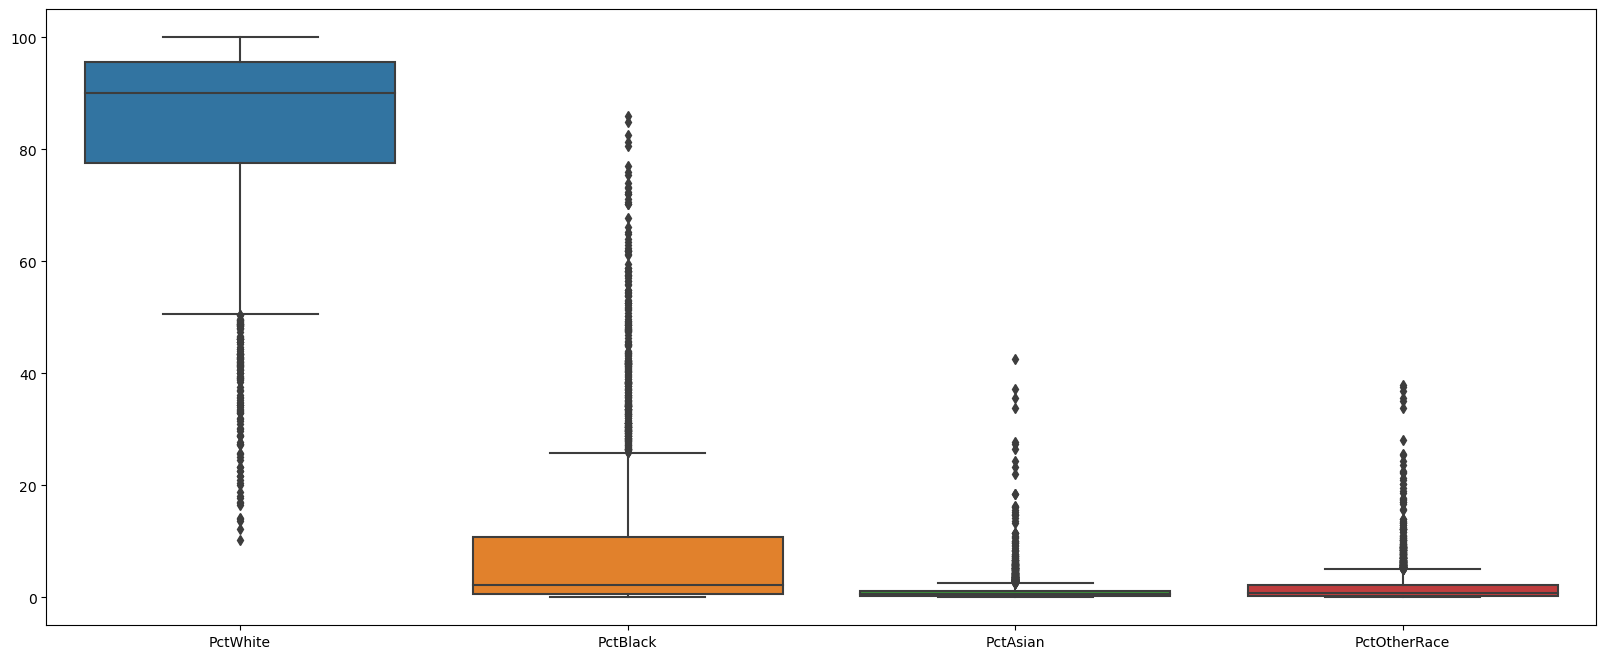

In [76]:
"""   
Se puede observar que hay valores que son muy pequeños como para ser consistentes con la realidad como 11%. Se puede contemplar la posibilidad de que esto se deba a que sea que algunos datos fueron digitados en formatos de porcentajes de 0 a 1 o de 0 a 100, no obstante, con el contexto actual del problema no es posible saber esto y determinarlo seria una tarea muy compleja y podria crear sesgos en el modelo de regresion por etnias.

Por lo que se propone una posible normalizacion sobre todas las columnas dado que no existe tupla cuya suma de los 4 porcentajes sea equivalente a 100%.

La manera en que se realizara esta normalizacion consiste en los siguientes pasos:
- Se hara un analisis descriptivo de las estadisticas de esas 4 columnas antes de la normalizacion, junto a un boxplot. Esto con el objetivo de posterior a la normalizacion comparar que tanto afecto la normalizacion a la naturaleza de los datos y si talvez no sea buena idea realizarla.
- Se hara la normalizacion: se dividira cada valor de cada columna sobre la suma de las 4 columnas, de manera que la suma de los nuevos valores nos den una suma de 100 (en escala de 0 a 100)
- Se hara un nuevo analisis descriptivo de estadisticas junto a un boxplot para analizar que tan bien es la normalizacion para los datos y si no afecta mucho a la naturaleza de los datos. Para anlizar la eficacia de la normalizacion se realizaran las siguientes comparaciones:
        - Comparar la media, la mediana, y la desviación estándar de cada columna antes y después de la normalización, y ver si hay diferencias grandes o pequeñas. Si hay diferencias grandes, significa que la normalización cambió mucho los valores y la dispersión de los datos. Si hay diferencias pequeñas, significa que la normalización no tuvo mucho efecto en los datos.
        - Comparar los diagramas de boxplot de cada columna antes y después de la normalización, y ver si hay cambios en la forma, la posición, y los valores atípicos de los datos. Si hay cambios, significa que la normalización alteró la distribución de los datos. Si no hay cambios, significa que la normalización mantuvo la distribución de los datos.
        - Adicional: verificar los valores de correlacion de cada columna respecto a la variable objetivo (deathRate) para identificar si hubo algun cambio significativo, si hay cambios significativos, significa que la normalización afectó la relación entre las variables. Si no hay cambios, significa que la normalización no tuvo mucho efecto en la relación entre las variables. Lo cual directamente no dice si eso mejora o empeora el modelo y tocaria ser testeado.
"""

target_cols = ["PctWhite", "PctBlack", "PctAsian", "PctOtherRace"]

print(train_data[target_cols].describe())

fig = plt.figure(figsize=(20,8))
ax = sns.boxplot(data=train_data[target_cols], orient="v")



In [77]:
"""   
3. Valores de edades en las columnas: MedianAge, MedianAgeMale, MedianAgeFemale

Las edades deben de estar representadas en valores que hagan sentido con la realidad hoy en dia. Por ejemplo, una mediana de un pueblo no puede ser mayor o igual a 100 debido a que una poblacion con esa mediana o esta llena de ancianos o simplemente no es coherente con la realidad de la edad de las personas.

A dia de hoy se sabe que la persona mas longeva que ha vivido en el planeta tierra es Jeanne Calment, con una edad de 122 años. Por lo que podriamos considerar esta como nuestra edad limite para la mediana de edad de un condado.
"""
age_limit = 122

# Verifica las estadísticas descriptivas de las columnas de edades
print(train_data[['MedianAge', 'MedianAgeMale', 'MedianAgeFemale']].describe())

# Busca edades incoherentes en las columnas de edades
incoherent_ages = train_data[(train_data['MedianAge'] > age_limit) | (train_data['MedianAgeMale'] > age_limit) | (train_data['MedianAgeFemale'] > age_limit)][['MedianAge', 'MedianAgeMale', 'MedianAgeFemale']]
print(incoherent_ages)


         MedianAge  MedianAgeMale  MedianAgeFemale
count  2132.000000    2132.000000      2132.000000
mean     44.298687      39.559475        42.140009
std      39.522898       5.208212         5.272267
min      23.500000      22.800000        22.800000
25%      37.700000      36.300000        39.000000
50%      40.900000      39.600000        42.300000
75%      44.000000      42.600000        45.400000
max     619.200000      64.700000        65.700000
      MedianAge  MedianAgeMale  MedianAgeFemale
30        525.6           41.6             46.2
171       470.4           37.7             40.5
495       406.8           33.3             34.4
556       414.0           33.3             35.6
743       430.8           32.3             39.2
847       523.2           42.4             45.4
981       508.8           41.6             43.2
1196      481.2           39.4             41.4
1302      424.8           34.2             36.8
1498      349.2           28.9             29.3
1770      546

In [78]:
"""   
Nos damos cuenta de que solo la columna MedianAge tiene un valor maximo inusual, sin embargo se hara limpieza de estos datos en todas las columnas para asegurarnos de que la calidad de datos se preserve ya que siguen existiendo valores mayores al limite en las demas columnas tambien. En lo que respecta a limpieza se debe tomar la decision de reemplazar estos datos o obtenerlos a partir de otras fuentes, pero solo tenemos la posibilidad de reemplazarlos o no tenerlos en cuenta en el modelo. Por lo que se buscara el porcentaje de estos valores atipicos en estas 3 columnas.
"""

columns = ['MedianAge', 'MedianAgeMale', 'MedianAgeFemale']
outlier_percentages = {}

for col in columns:
    # Cuenta el número de valores atípicos en la columna
    num_outliers = len(train_data[train_data[col] > age_limit])
    
    # Calcula el porcentaje de valores atípicos
    outlier_percentage = num_outliers / len(train_data) * 100
    
    # Guarda el porcentaje en el diccionario
    outlier_percentages[col] = outlier_percentage

# Imprime el diccionario de porcentajes de valores atípicos
for col, percentage in outlier_percentages.items():
    print(f'{col}: {percentage}%')

MedianAge: 0.797373358348968%
MedianAgeMale: 0.0%
MedianAgeFemale: 0.0%


Finalmente solo el 0.79% de los datos de la columna MedianAge tiene estos valores atipicos, por lo tanto seran reemplazados por la mediana de los datos de esa columna.

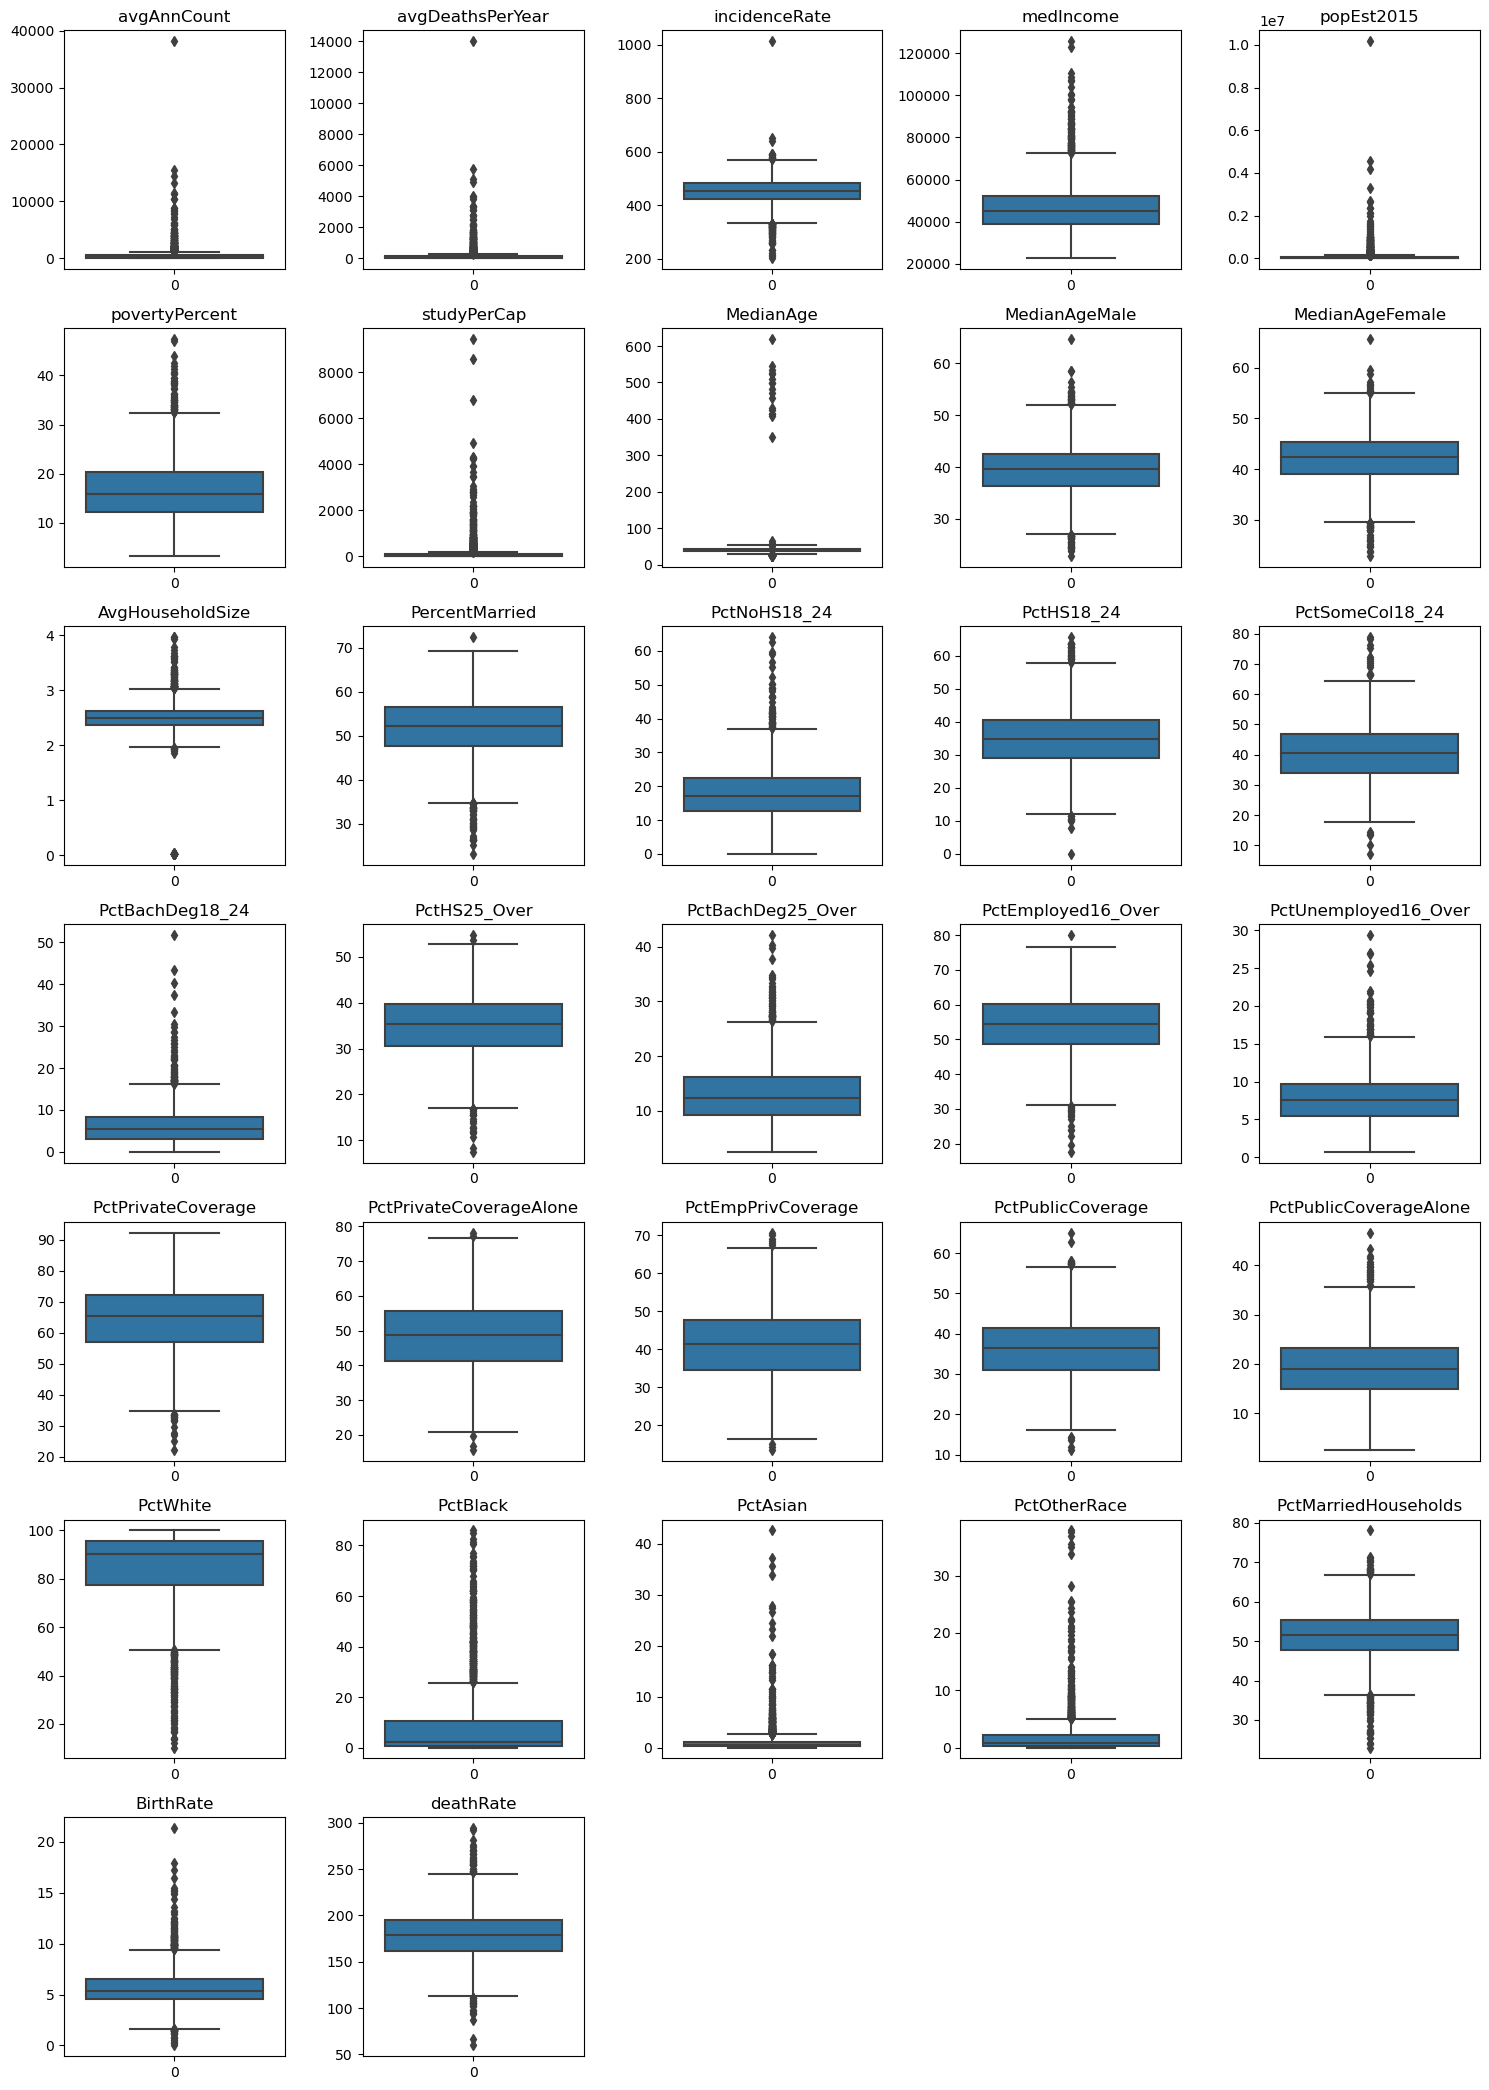

In [79]:
"""   
Identificacion de outliers: para la identificacion de outliers sobre todas las columnas numericas de tipo int64 o float64 se hara por medio del metodo de IQR, donde todos los valores que se encuentren debajo del primer quartil - 1.5*IQR o encima del tercer quartil + 1.5*IQR es considerado un outlier. IQR = Q3 - Q1, quartil 1 = 0.25, quartil 3 = 0.75
"""

# Selecciona las columnas numéricas
numeric_cols = train_data.select_dtypes(include=["int64", "float64"]).columns

# Define el número de filas y columnas para tus gráficas
n_cols = 5  # Número de columnas
n_rows = -(-len(numeric_cols) // n_cols)  # Número de filas

# Crea una figura y ejes con matplotlib
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# Asegúrate de que axs sea una lista 2D
if n_rows == 1:
    axs = [axs]

# Crea las gráficas
for i, col in enumerate(numeric_cols):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(data=train_data[numeric_cols[i]], orient="v", ax=axs[row][col])
    axs[row][col].set_title(numeric_cols[i])  # Agrega el nombre de la columna como título

# Elimina los ejes vacíos
for i in range(len(numeric_cols), n_rows*n_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()



c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


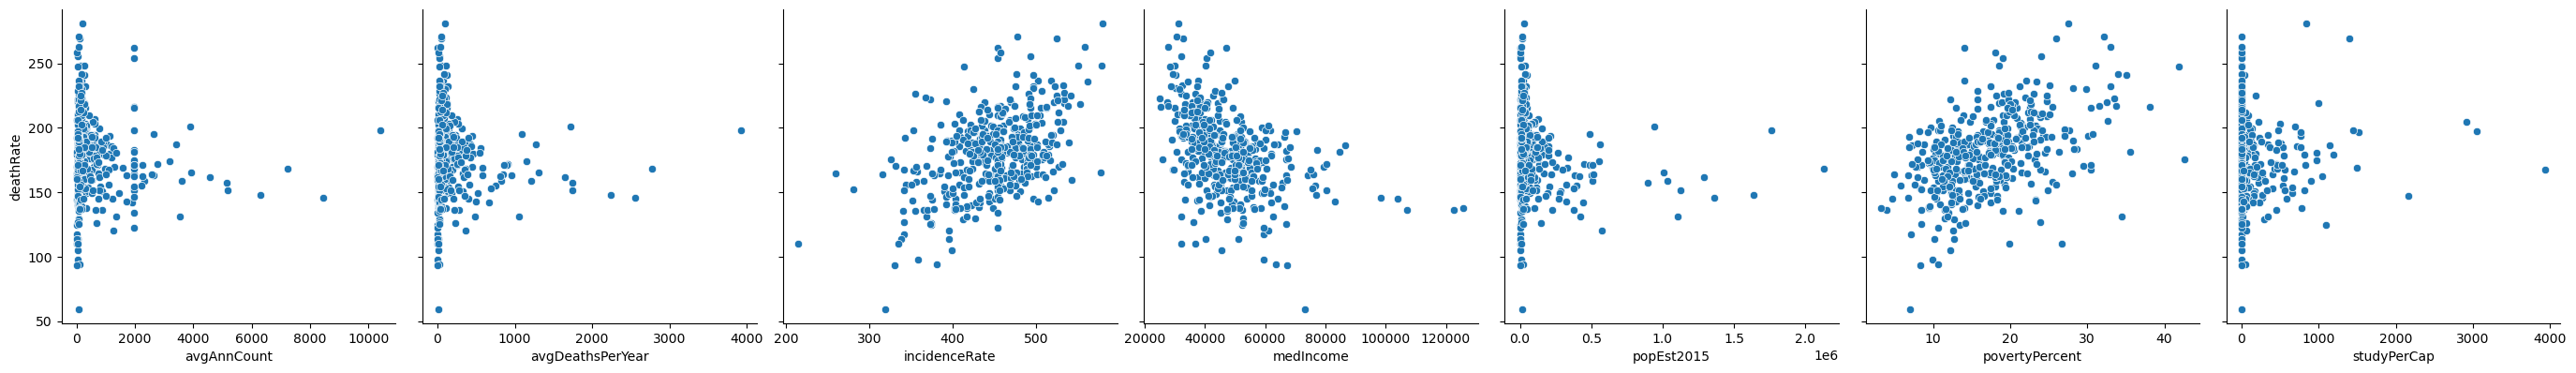

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


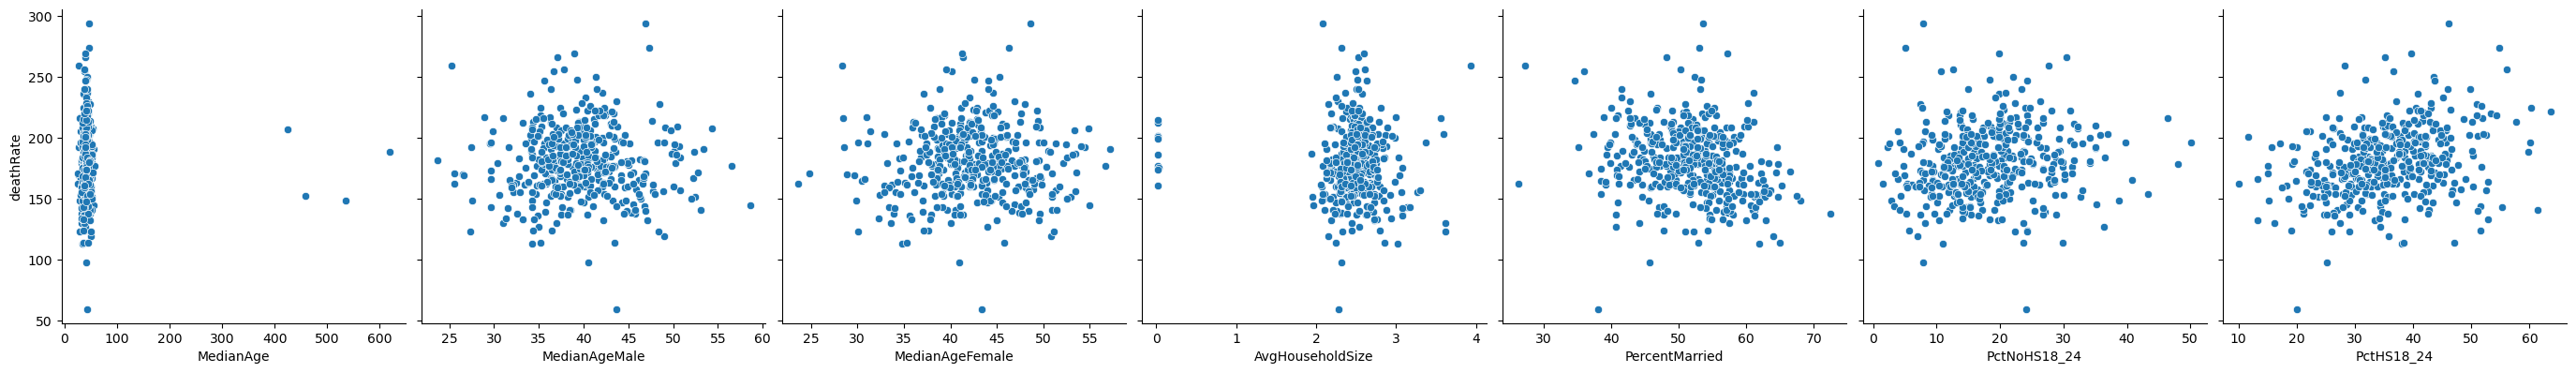

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


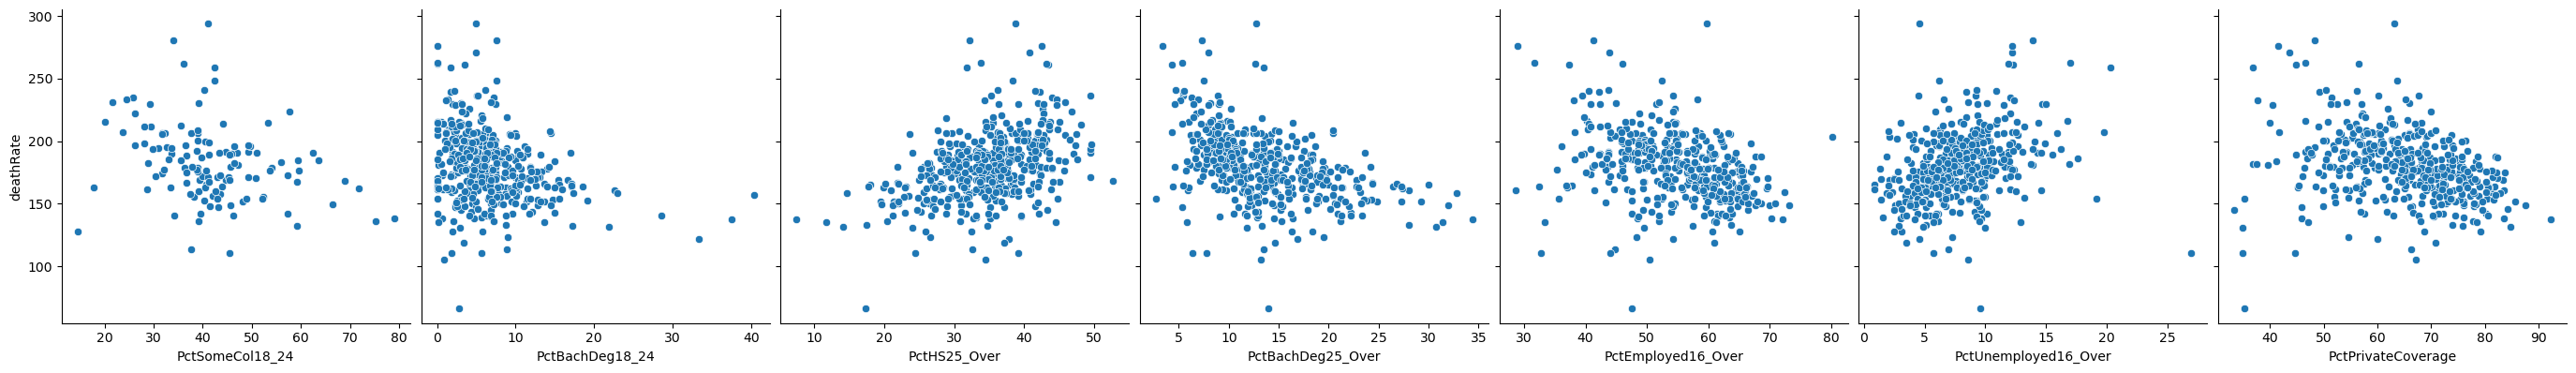

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


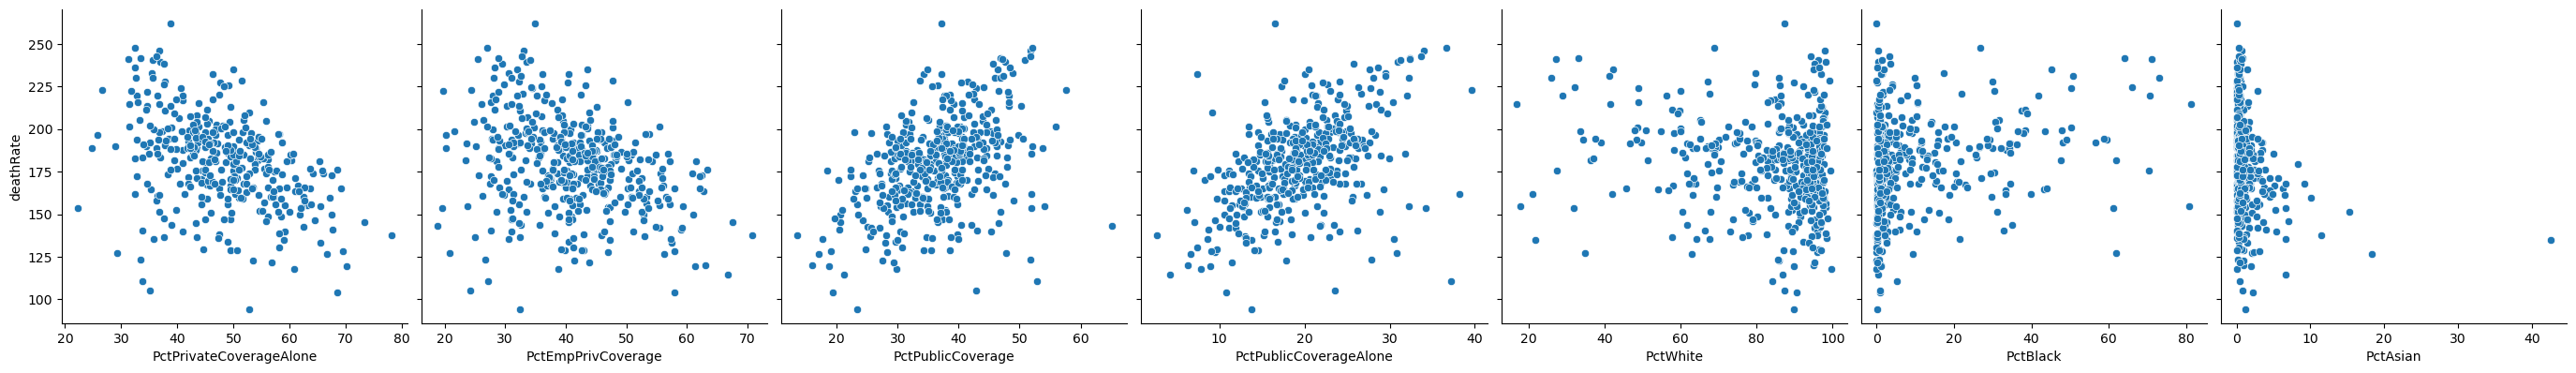

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


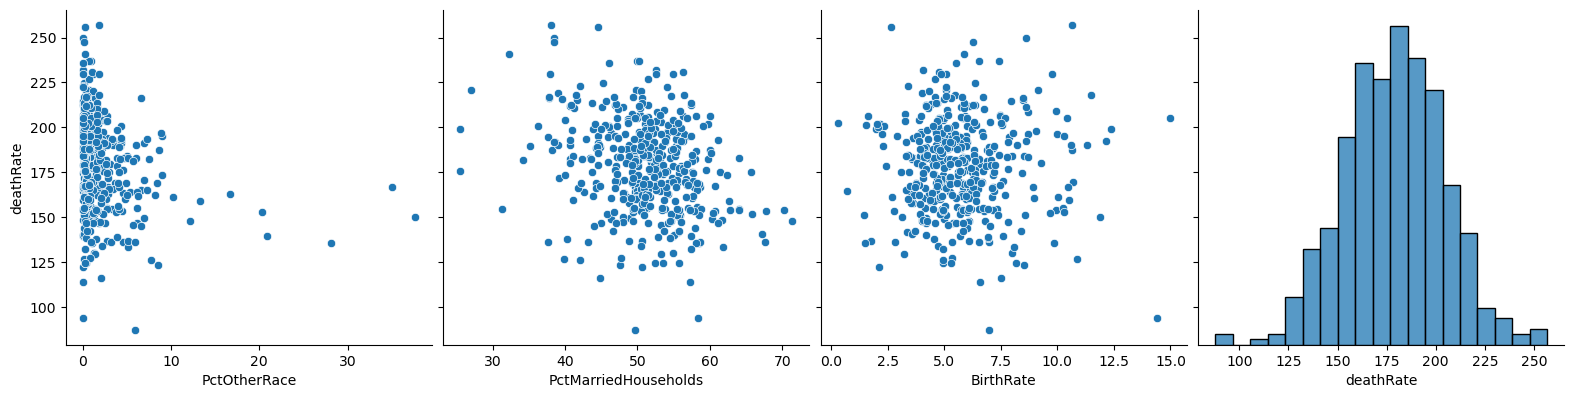

In [80]:
"""   
Analisis de relaciones con la variable objetivo

Se hara una grafica de scatter donde se puedan observar las relaciones de las demas variables numericas contra la objetivo, deathRate, aunque se esta excluyendo la columna binnedInd debido a que esta es interpretada como un object y no ha sido transformada y preparada todavia. Es por esto que se hara una verificacion de supuestos una vez se halla hecho la limpieza de los datos, de manera que se pueda visualizar el cambio entre relaciones con la variable objetivo y tambien se pueda ver la columna binnedInd
"""

# Selecciona las columnas numéricas
features = train_data.select_dtypes(include=["int64", "float64"]).columns

# Define el número de columnas por fila
n_cols = 7

# Divide las características en grupos de n_cols
feature_groups = [features[n:n+n_cols] for n in range(0, len(features), n_cols)]

# Crea un pairplot para cada grupo de características
for i, feature_group in enumerate(feature_groups):
    sns.pairplot(train_data.sample(frac=0.2), height=4, y_vars="deathRate", x_vars=feature_group, kind="scatter")
    plt.show()

En algunas de las graficas notamos que existen muchos valores pegados al eje x = 0, debido a que tienen muchos valores cercanos o iguales a 0 en el eje X y tambien por la presencia de outliers, los cuales amplian significativamente el rango del eje X y que por lo tanto sea dificil visualizar las relaciones. Por lo que para esto se hara una revalidacion de supuestos despues de la limpieza de los datos.

                  feature1     feature2  correlation
0              avgAnnCount  avgAnnCount     1.000000
1         avgDeathsPerYear  avgAnnCount     0.935807
2            incidenceRate  avgAnnCount     0.072286
3                medIncome  avgAnnCount     0.261289
4               popEst2015  avgAnnCount     0.923980
...                    ...          ...          ...
1019              PctAsian    deathRate    -0.189987
1020          PctOtherRace    deathRate    -0.166330
1021  PctMarriedHouseholds    deathRate    -0.284380
1022             BirthRate    deathRate    -0.069832
1023             deathRate    deathRate     1.000000

[1024 rows x 3 columns]


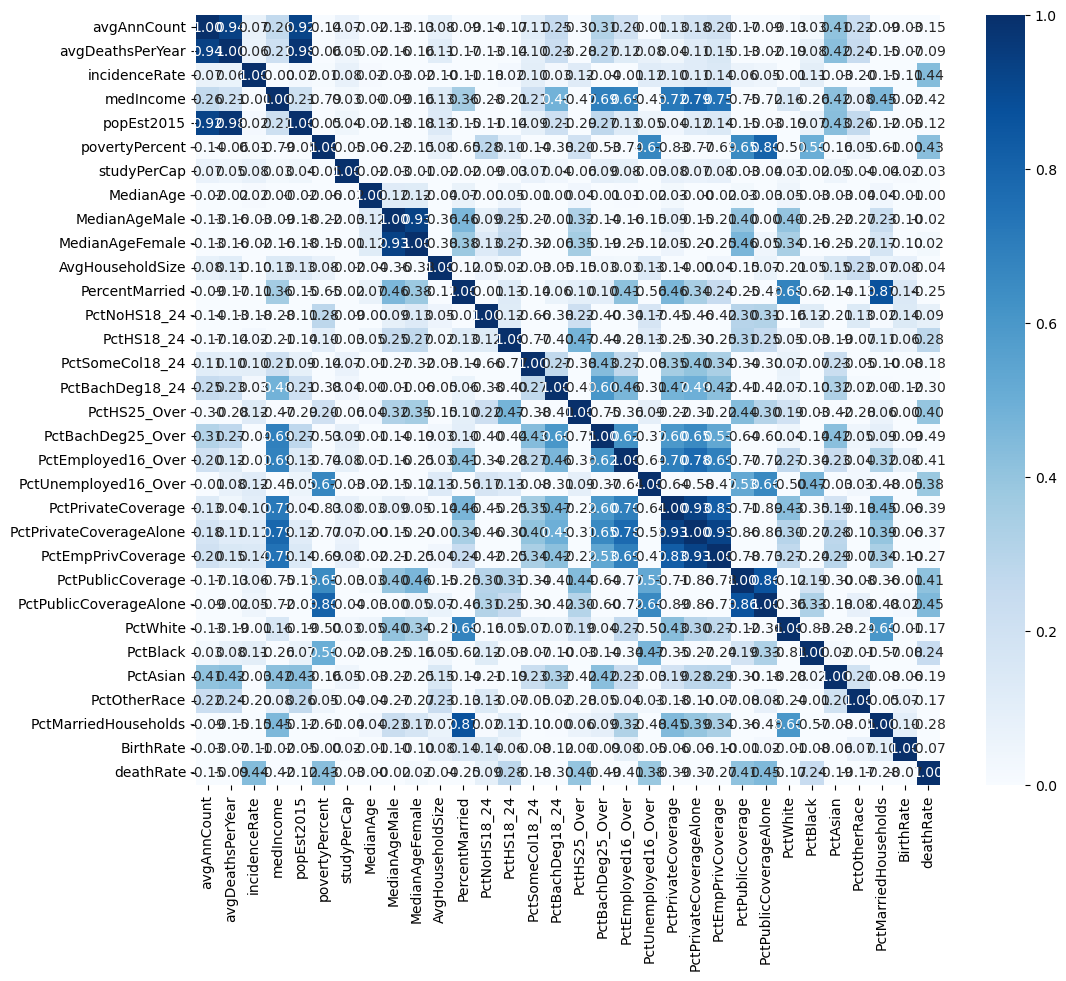

In [81]:
"""   
Correlaciones entre cada variable
"""

# Calcula la matriz de correlación
corr_matrix = train_data[features].corr()

# Crea una tabla de correlación
corr_table = pd.melt(corr_matrix.reset_index(), id_vars='index') # convierte la matriz de correlación en formato largo
corr_table.columns = ['feature1', 'feature2', 'correlation'] # renombra las columnas

# Muestra la tabla de correlación
print(corr_table)

# Crea un mapa de calor de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="Blues", vmin=0, vmax=1, annot=True, fmt=".2f")
plt.show()

##### **3. Limpieza y preparacion de datos**

Para la limpieza y preparacion de datos se seguiran los siguientes pasos en orden:

1. Convertir valores de rangos de la columna binnedInc al promedio del rango
2. Remover tuplas totalmente duplicados respecto a todas las columnas en conjunto
3. Remover outliers con el metodo IQR en todas las columnas numericas tipo float64 o int64
4. Reemplazar con la mediana a los valores tipo float de la columna "avgAnnCount"
5. Se hara la normalizacion de las columnas (PctWhite, PctBlack, PctAsian, PctOtherRace): se dividira cada valor de cada columna sobre la suma de las 4 columnas, de manera que la suma de los nuevos valores nos den una suma de 100 (en escala de 0 a 100)
6. Reemplazar los valores de la columna MedianAge con valores mayores a 122 con la mediana de la columna
7. Elimnar columna PctSomeCol18_24 de los datos

In [82]:
"""   
Limpieza de datos
1. Convertir valores de rangos de la columna binnedInc al promedio del rango
"""

def average_range(range_str):
    # Verifica si range_str es una cadena de texto
    if isinstance(range_str, str):
        # Elimina los paréntesis o corchetes
        range_str = range_str.replace('(', '').replace(')', '').replace('[', '').replace(']', '')
        # Extrae los límites del rango
        lower, upper = map(float, range_str.split(','))
        # Calcula y devuelve el promedio del rango
        return (lower + upper) / 2
    else:
        # Si range_str no es una cadena de texto, devuelve el valor tal cual
        return range_str

# Aplica la función a la columna 'binnedInc'
train_data['binnedInc'] = train_data['binnedInc'].apply(average_range)
print(f"\n\nTipos de datos: {train_data['binnedInc'].describe()}\n\n")
train_data['binnedInc']



Tipos de datos: count     2132.000000
mean     48736.965924
std      16735.124144
min      28429.050000
25%      38888.250000
50%      45287.000000
75%      52796.000000
max      93564.750000
Name: binnedInc, dtype: float64




0       35815.95
1       49534.00
2       58020.05
3       28429.05
4       38888.25
          ...   
2127    28429.05
2128    93564.75
2129    93564.75
2130    58020.05
2131    58020.05
Name: binnedInc, Length: 2132, dtype: float64

In [83]:
"""   
Limpieza de datos
2. Remover tuplas totalmente duplicados respecto a todas las columnas en conjunto
"""

# Calcula el número total de filas antes de eliminar las duplicadas
total_rows_before = len(train_data)

# Encuentra las filas duplicadas
duplicated_rows_before = train_data[train_data.duplicated()]

# Calcula e imprime el número y el porcentaje de filas duplicadas
num_duplicated_before = len(duplicated_rows_before)
print(f"Número de filas duplicadas antes de la limpieza: {num_duplicated_before}")

# Elimina las filas duplicadas
train_data = train_data.drop_duplicates()

# Encuentra las filas duplicadas después de la limpieza
duplicated_rows_after = train_data[train_data.duplicated()]

# Calcula e imprime el número de filas duplicadas después de la limpieza
num_duplicated_after = len(duplicated_rows_after)
print(f"Número de filas duplicadas después de la limpieza: {num_duplicated_after}")

# Calcula e imprime el número y el porcentaje de filas después de eliminar las duplicadas
total_rows_after = len(train_data)
print(f"Número de filas después de eliminar las duplicadas: {total_rows_after}")

Número de filas duplicadas antes de la limpieza: 0
Número de filas duplicadas después de la limpieza: 0
Número de filas después de eliminar las duplicadas: 2132


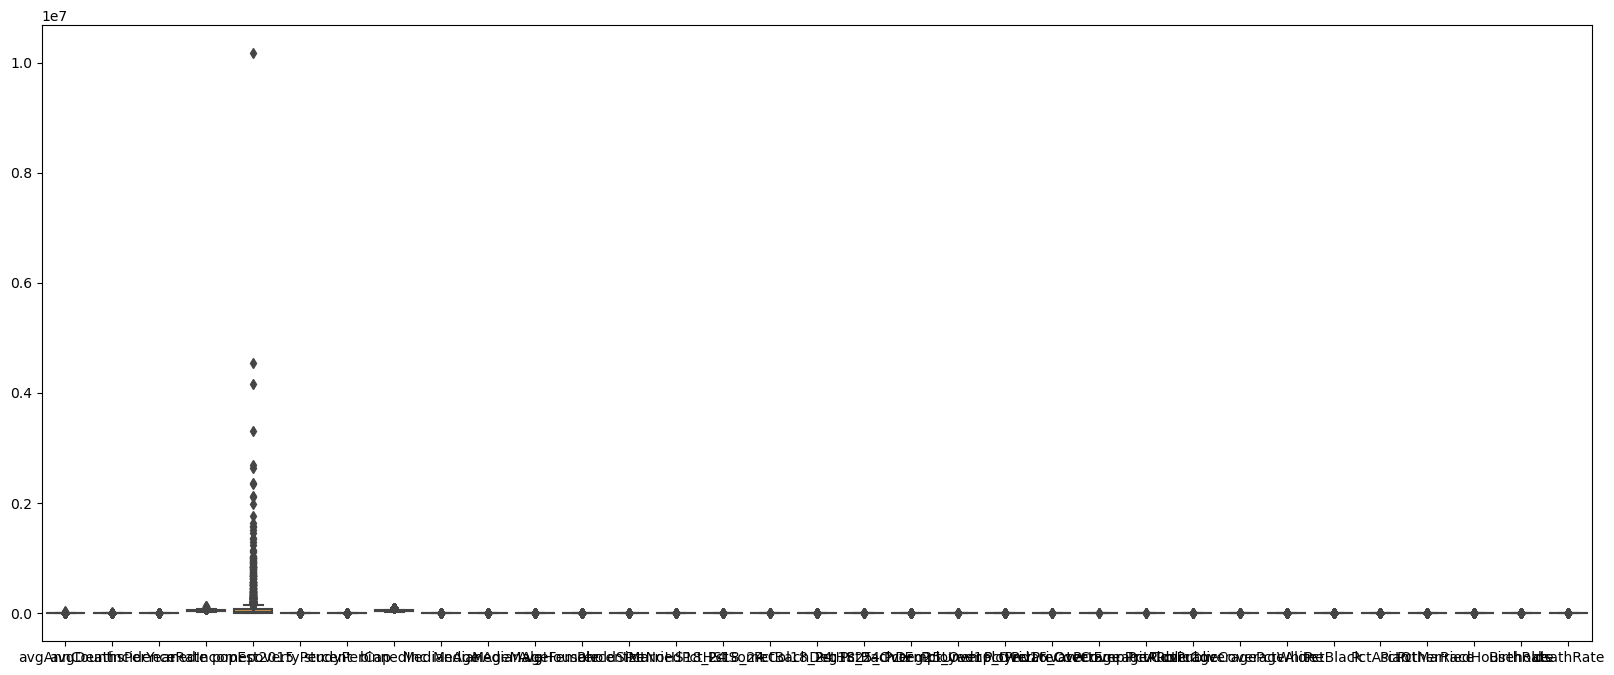

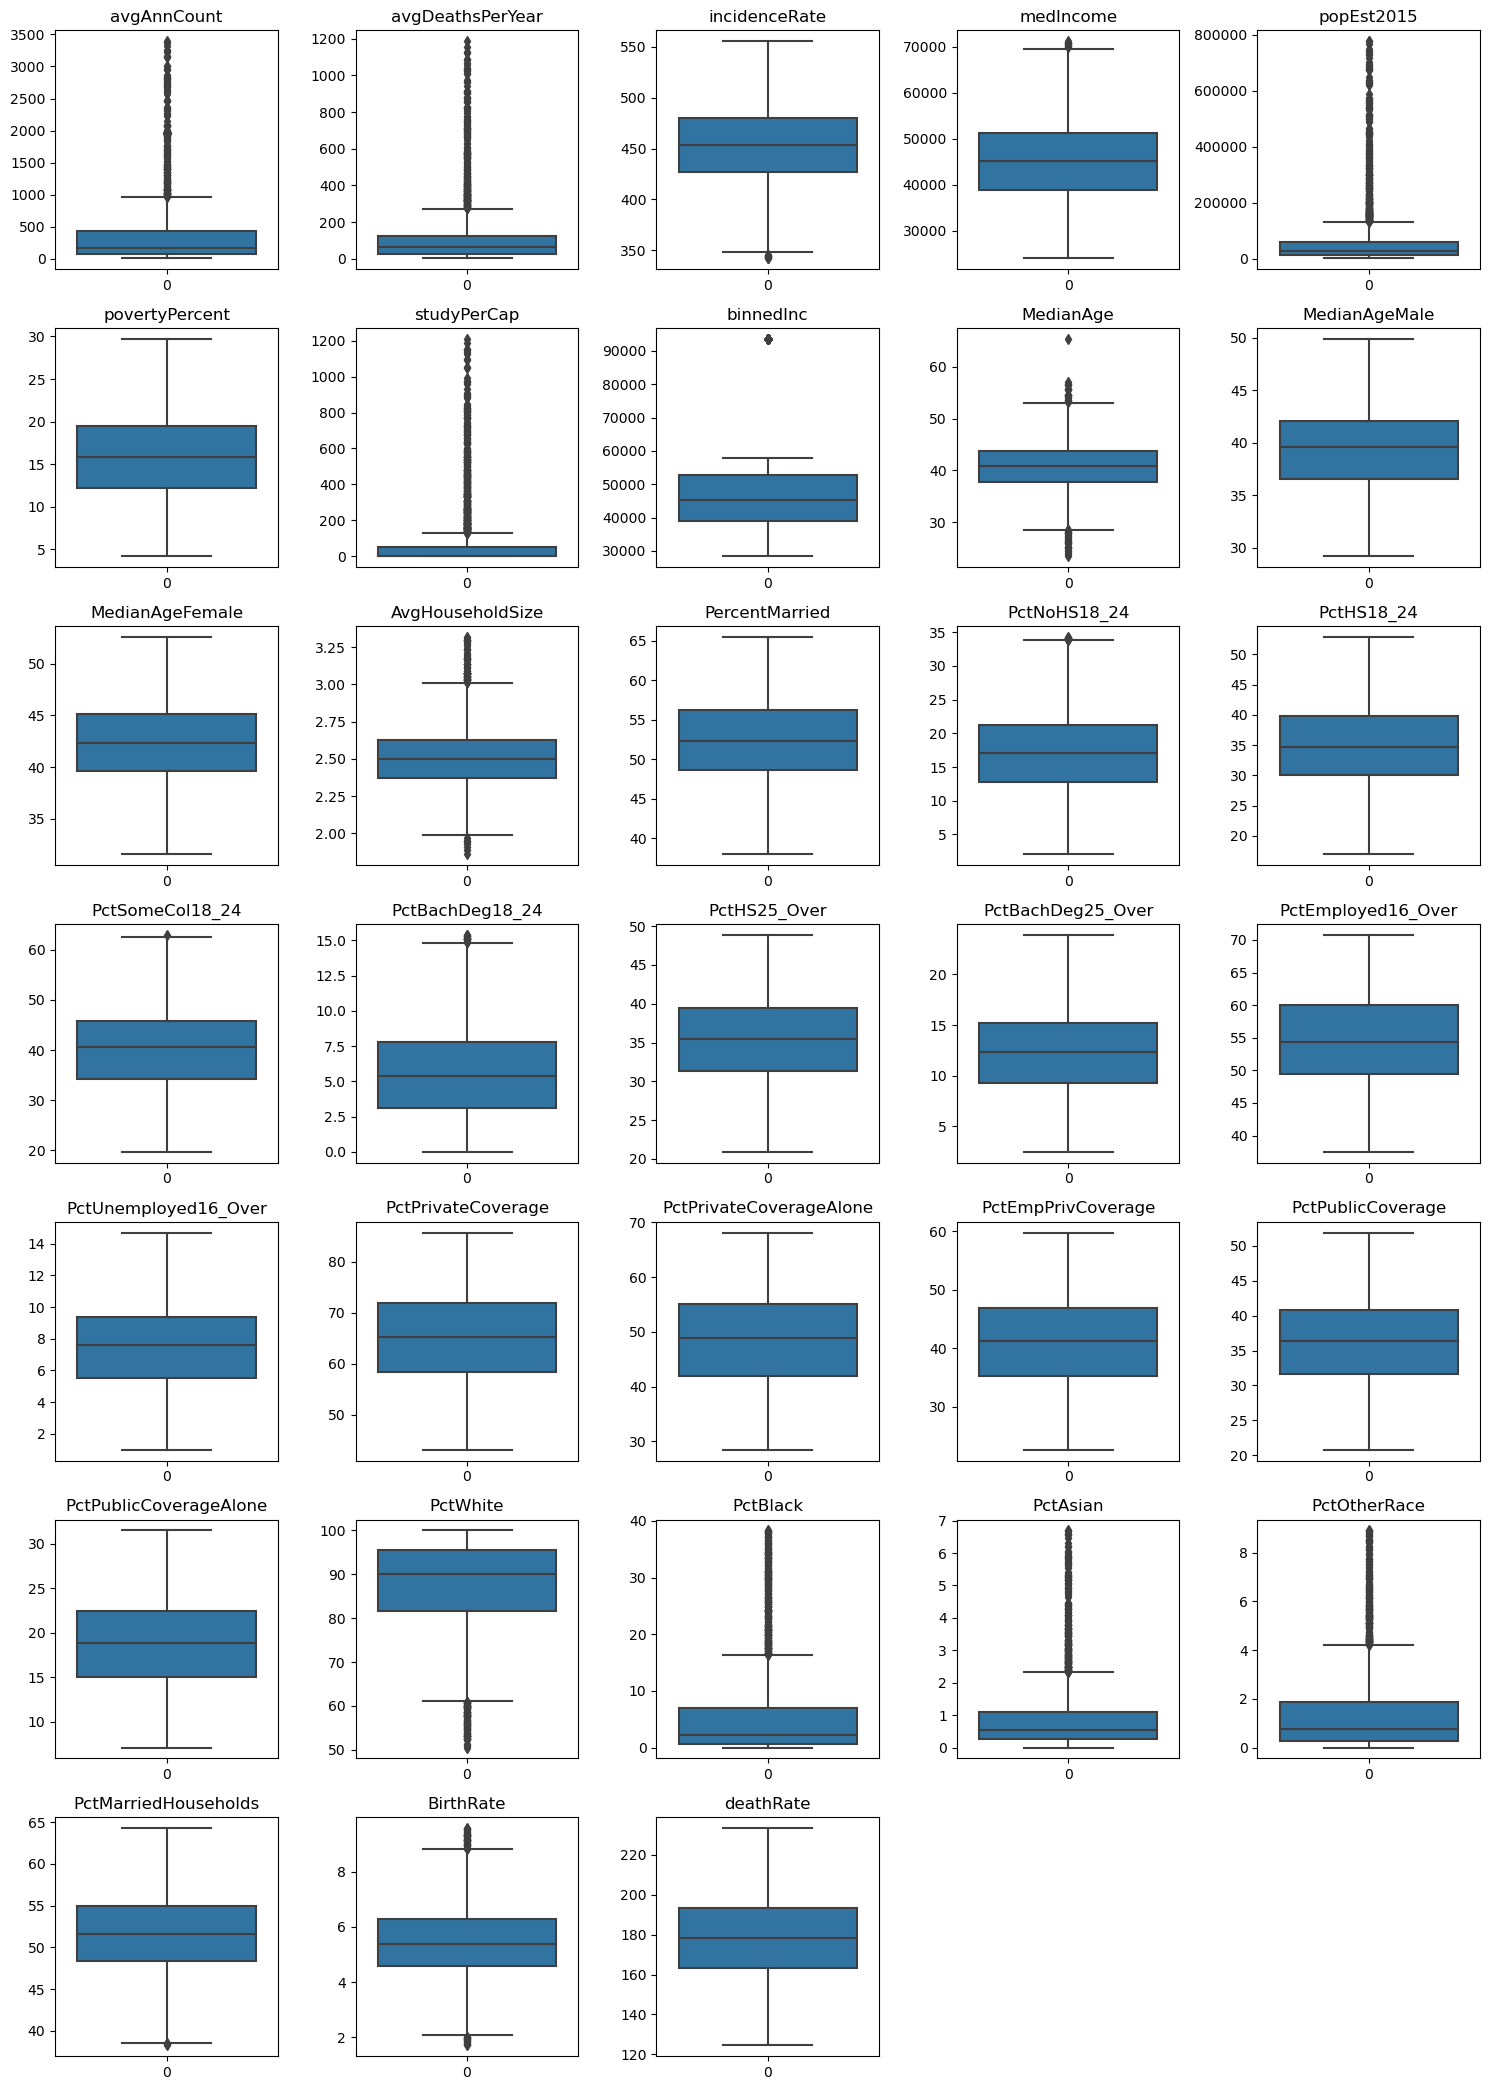

In [84]:
"""   
Limpieza de datos
3. Remover outliers con el metodo IQR en todas las columnas numericas tipo float64 o int64
"""

# Antes: deteccion de outliers, se hara por medio de la eleccion de cualquier tupla que tenga como valor en balance mayor a n la desviacion estandar de la columna balance. En este caso n = 3.

# Reemplazaremos los valores no consistentes por la mediana de la columna

# Deteccion de outliers
cols_to_check = features
n = 2

# Antes de la limpieza
fig = plt.figure(figsize=(20, 8))
ax = sns.boxplot(data=train_data, orient="v")


for col in cols_to_check:
    mean = train_data[col].mean()
    std = train_data[col].std()
    
    # Replace outliers with the median value
    train_data.loc[train_data[col] > (mean + n * std), col] = train_data[col].median()
    train_data.loc[train_data[col] < (mean - n * std), col] = train_data[col].median()

# Despues de la limpieza

# Selecciona las columnas numéricas
numeric_cols = train_data.select_dtypes(include=["int64", "float64"]).columns

# Define el número de filas y columnas para tus gráficas
n_cols = 5  # Número de columnas
n_rows = -(-len(numeric_cols) // n_cols)  # Número de filas

# Crea una figura y ejes con matplotlib
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# Asegúrate de que axs sea una lista 2D
if n_rows == 1:
    axs = [axs]

# Crea las gráficas
for i, col in enumerate(numeric_cols):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(data=train_data[numeric_cols[i]], orient="v", ax=axs[row][col])
    axs[row][col].set_title(numeric_cols[i])  # Agrega el nombre de la columna como título

# Elimina los ejes vacíos
for i in range(len(numeric_cols), n_rows*n_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()


Si se compara con los boxplots anteriores hubo un cambio positivo y muchos outliers fueron eliminados.

In [85]:
"""   
Limpieza de datos
4. Reemplazar con la mediana a los valores tipo float de la columna "avgAnnCount"
"""

# Calcula la mediana de la columna "avgAnnCount"
median = round(train_data['avgAnnCount'].median())
print(f"Median: {median}")

# Obtiene los valores únicos en la columna "avgAnnCount"
bag = train_data["avgAnnCount"].unique()

# Inicializa una lista vacía para almacenar los valores de tipo float
floats = []

# Itera sobre los valores únicos
for val in bag:
    # Comprueba si el valor es de tipo float
    decimal, integer = math.modf(val)
    if abs(decimal) > 0: 
        floats.append(val)
        
print(f"\nAntes: {floats}")

# Reemplaza los valores de tipo float en la columna "avgAnnCount" con la mediana
for float_val in floats:
    train_data['avgAnnCount'] = train_data['avgAnnCount'].replace(float_val, median)

bag = train_data["avgAnnCount"].unique()

floats = []

for val in bag:
    decimal, integer = math.modf(val)
    if abs(decimal) > 0: 
        floats.append(val)
                
print(f"\nDespues: {floats}")

print(train_data["avgAnnCount"].describe())

Median: 174

Antes: [174.5, 1962.667684]

Despues: []
count    2132.000000
mean      313.813790
std       484.528888
min         6.000000
25%        77.000000
50%       174.000000
75%       299.250000
max      3395.000000
Name: avgAnnCount, dtype: float64


In [86]:
"""   
Limpieza de datos
5. Se hara la normalizacion de las columnas (PctWhite, PctBlack, PctAsian, PctOtherRace): se dividira cada valor de cada columna sobre la suma de las 4 columnas, de manera que la suma de los nuevos valores nos den una suma de 100 (en escala de 0 a 100)
"""

# Define las columnas a normalizar
columns_to_normalize = ["PctWhite", "PctBlack", "PctAsian", "PctOtherRace"]

# Calcula la suma de las columnas a normalizar para cada fila antes de la normalización
row_sums_before = train_data[columns_to_normalize].sum(axis=1)

# Normaliza las columnas dividiendo cada valor por la suma de las columnas correspondientes y multiplicando por 100
for col in columns_to_normalize:
    train_data[col] = train_data[col] / row_sums_before * 100

# Calcula la suma de las columnas a normalizar para cada fila después de la normalización
row_sums_after = train_data[columns_to_normalize].sum(axis=1)

# Imprime las sumas antes y después de la normalización
print(f"Suma de las columnas antes de la normalización:\n{row_sums_before}")
print(f"Suma de las columnas después de la normalización:\n{row_sums_after}")


Suma de las columnas antes de la normalización:
0       89.966872
1       98.886674
2       98.075132
3       92.724430
4       93.356213
          ...    
2127    94.301618
2128    97.141225
2129    87.946075
2130    98.202738
2131    95.319662
Length: 2132, dtype: float64
Suma de las columnas después de la normalización:
0       100.0
1       100.0
2       100.0
3       100.0
4       100.0
        ...  
2127    100.0
2128    100.0
2129    100.0
2130    100.0
2131    100.0
Length: 2132, dtype: float64


In [87]:
"""   
Limpieza de datos
6. Reemplazar los valores de la columna MedianAge con valores mayores a 122 con la mediana de la columna
"""

# Calcula la mediana de la columna "MedianAge"
median = train_data['MedianAge'].median()

# Reemplaza los valores mayores a 122 en la columna "MedianAge" con la mediana
train_data.loc[train_data['MedianAge'] > 122, 'MedianAge'] = median

train_data['MedianAge'].describe()

count    2132.000000
mean       40.824437
std         5.154977
min        23.500000
25%        37.700000
50%        40.900000
75%        43.800000
max        65.300000
Name: MedianAge, dtype: float64

In [88]:
"""   
Limpieza de datos
7. Eliminar columna PctSomeCol18_24 de los datos
"""

train_data = train_data.drop(columns=['PctSomeCol18_24'])

##### **4. Validacion de supuestos**

Se revalidaran las correlaciones entre las variables y las relaciones de cada variable vs la variable objetivo

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


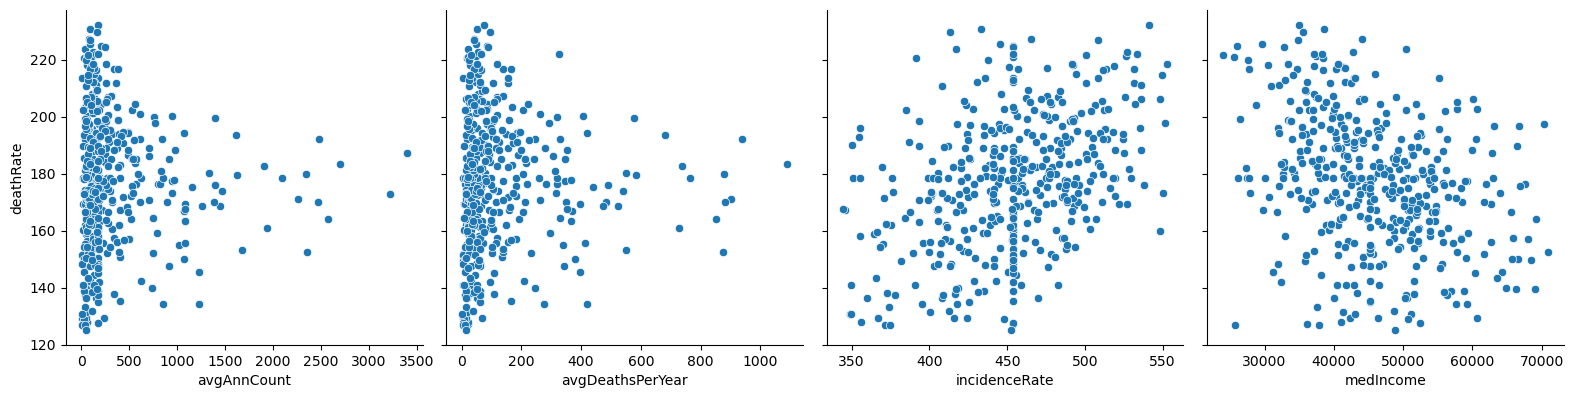

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


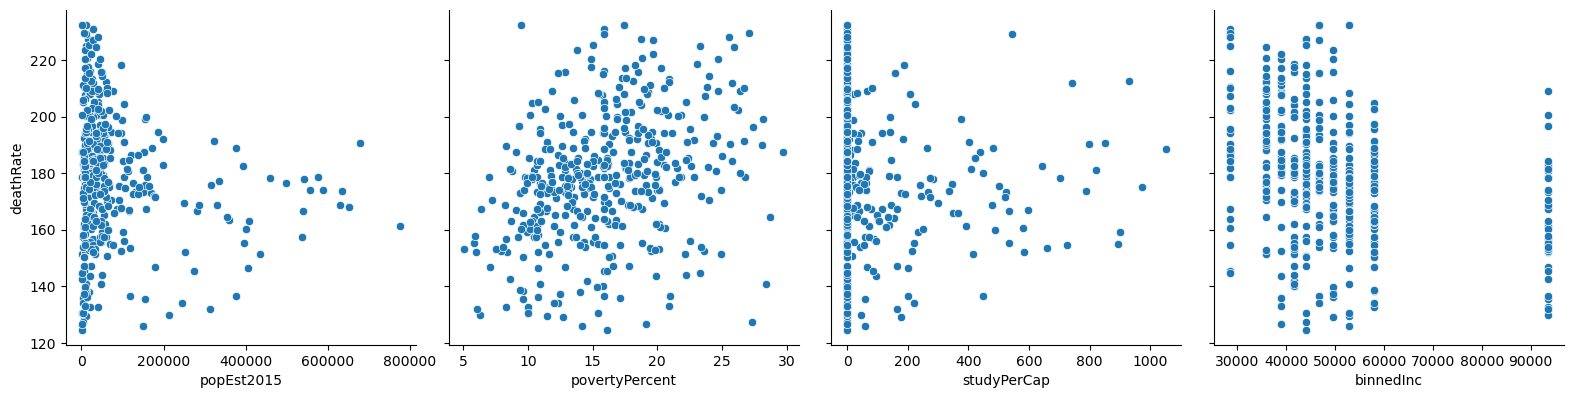

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


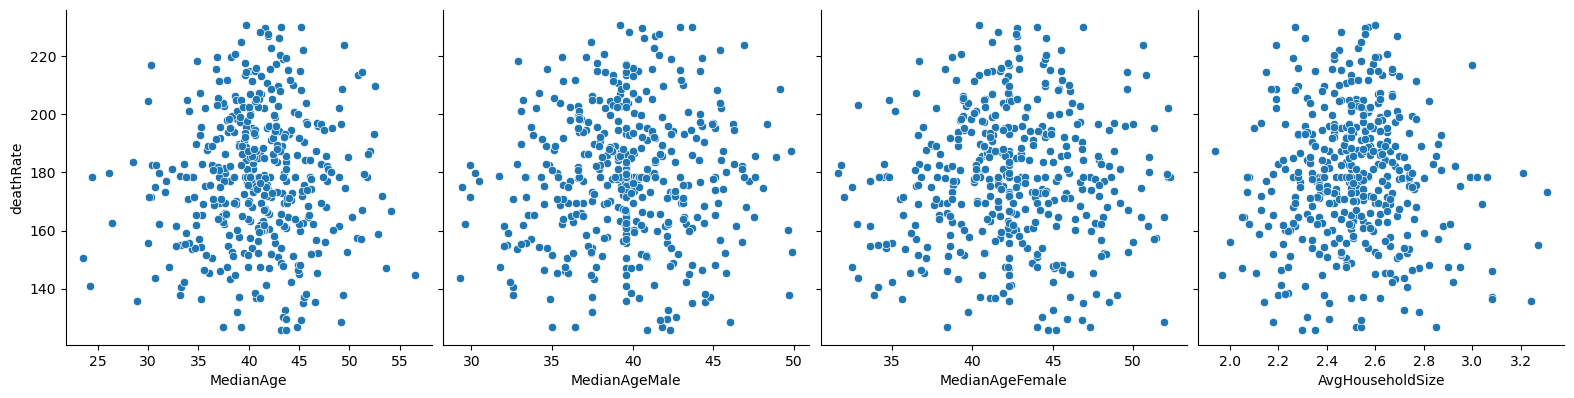

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


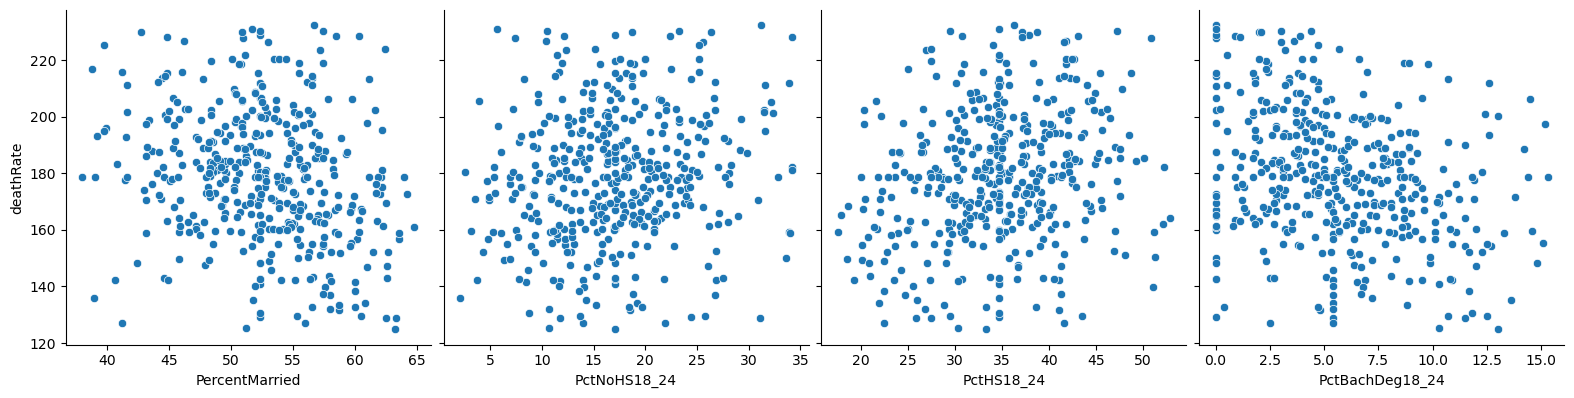

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


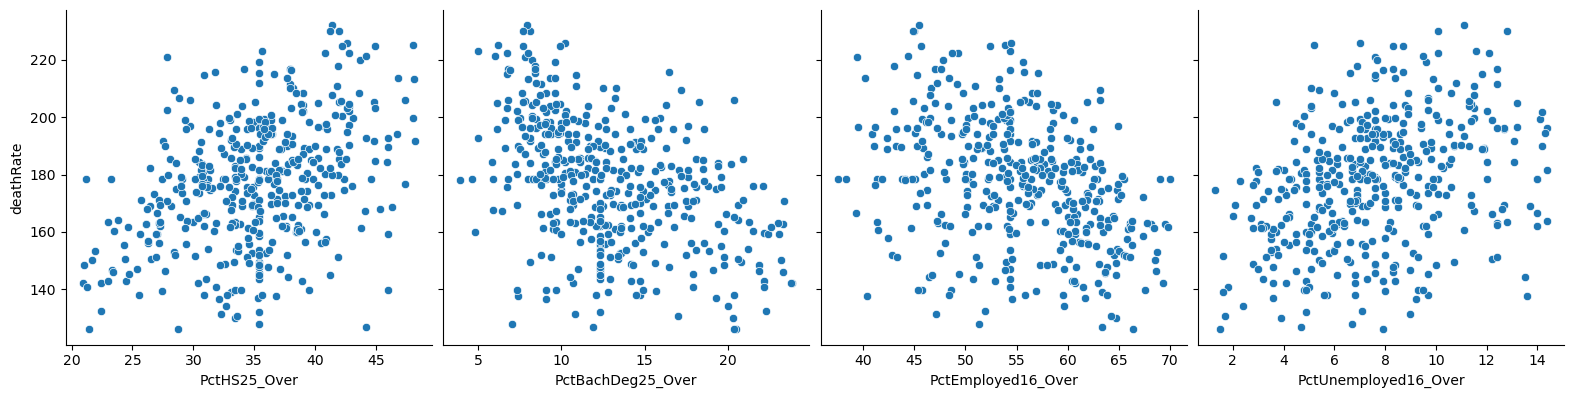

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


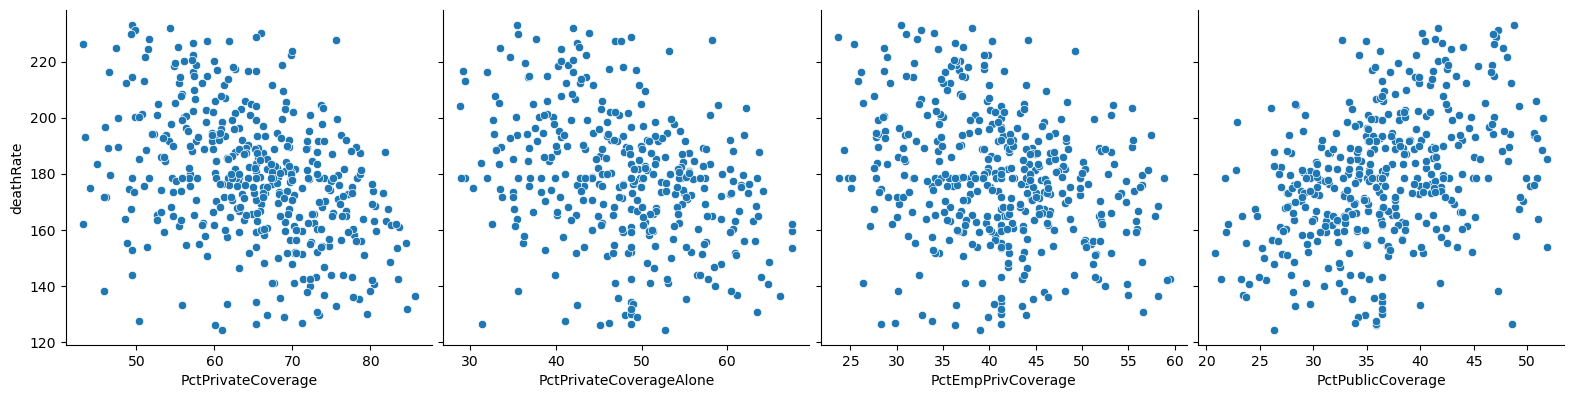

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


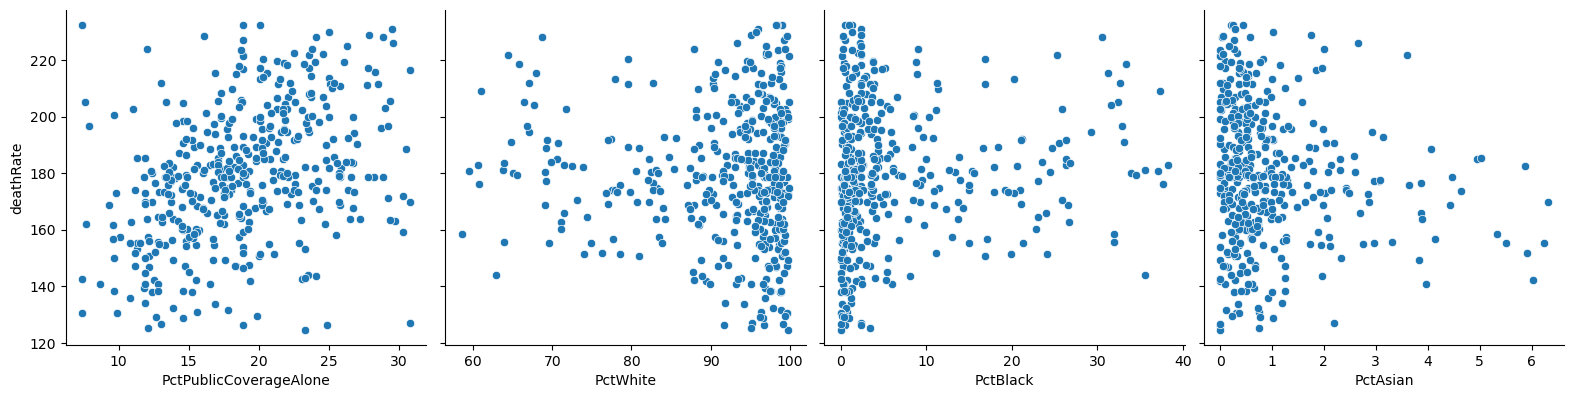

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


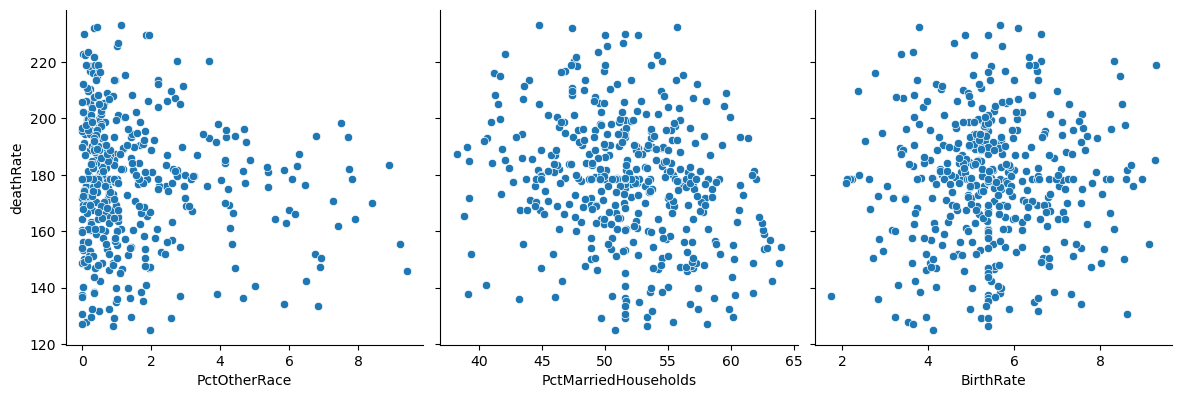

In [89]:
"""   
Analisis de relaciones con la variable objetivo
"""

# Selecciona las columnas numéricas
features = train_data.select_dtypes(include=["int64", "float64"]).columns
features = features.drop('deathRate')

# Define el número de columnas por fila
n_cols = 4

# Divide las características en grupos de n_cols
feature_groups = [features[n:n+n_cols] for n in range(0, len(features), n_cols)]

# Crea un pairplot para cada grupo de características
for i, feature_group in enumerate(feature_groups):
    sns.pairplot(train_data.sample(frac=0.2), height=4, y_vars="deathRate", x_vars=feature_group, kind="scatter")
    plt.show()

                 feature1     feature2  correlation
0             avgAnnCount  avgAnnCount     1.000000
1        avgDeathsPerYear  avgAnnCount     0.851766
2           incidenceRate  avgAnnCount     0.136650
3               medIncome  avgAnnCount     0.227151
4              popEst2015  avgAnnCount     0.837260
..                    ...          ...          ...
956              PctBlack    BirthRate    -0.047282
957              PctAsian    BirthRate    -0.056809
958          PctOtherRace    BirthRate     0.111142
959  PctMarriedHouseholds    BirthRate     0.071903
960             BirthRate    BirthRate     1.000000

[961 rows x 3 columns]


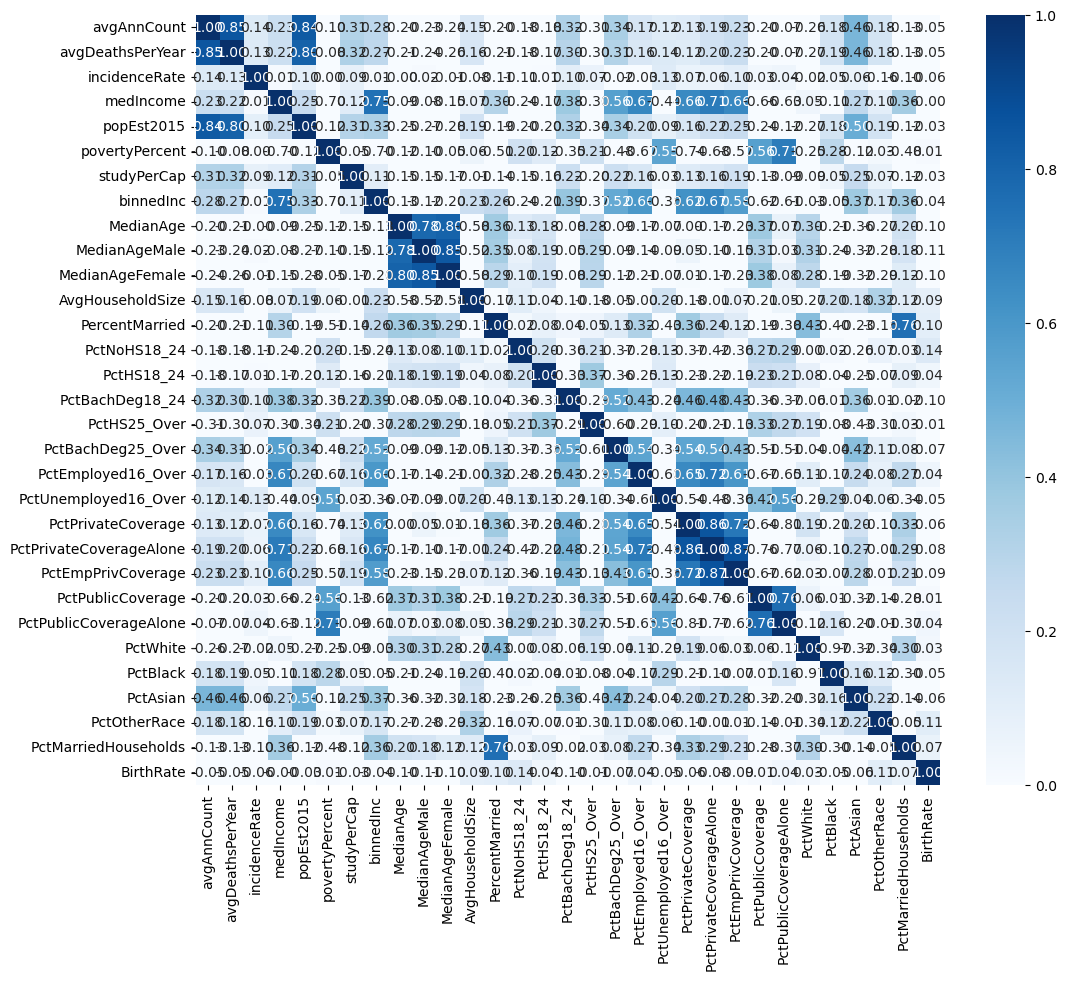

In [90]:
"""   
Correlaciones entre cada variable
"""

# Calcula la matriz de correlación
corr_matrix = train_data[features].corr()

# Crea una tabla de correlación
corr_table = pd.melt(corr_matrix.reset_index(), id_vars='index') # convierte la matriz de correlación en formato largo
corr_table.columns = ['feature1', 'feature2', 'correlation'] # renombra las columnas

# Muestra la tabla de correlación
print(corr_table)

# Crea un mapa de calor de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="Blues", vmin=0, vmax=1, annot=True, fmt=".2f")
plt.show()

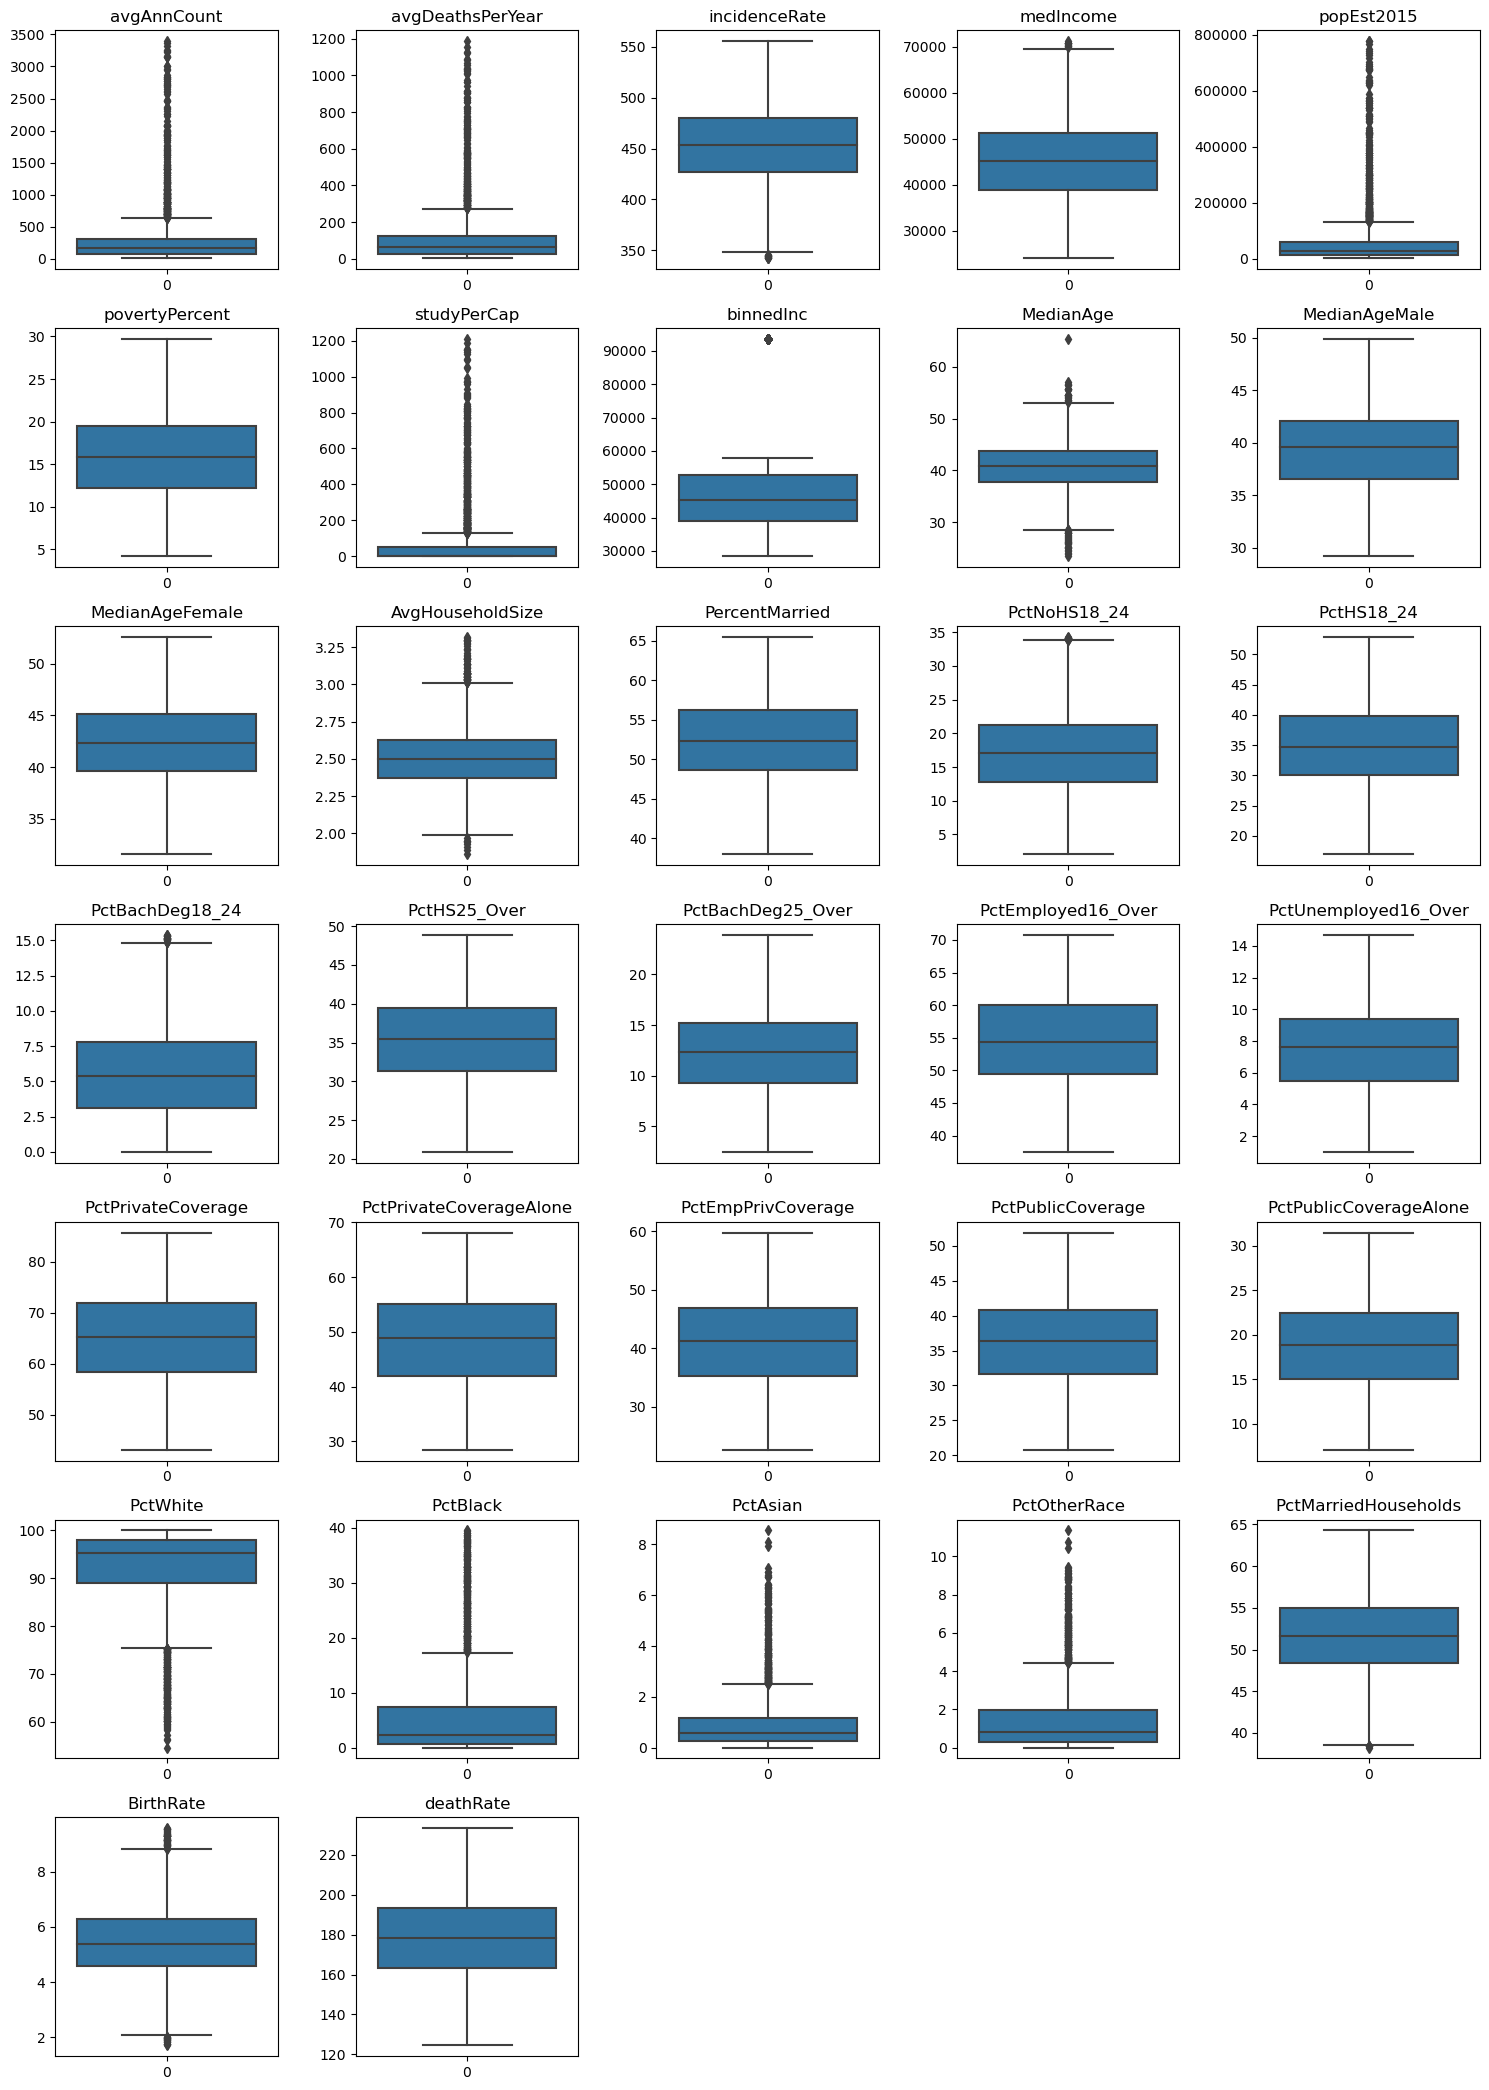

In [91]:
"""   
Identificacion de outliers nuevamente
"""

# Selecciona las columnas numéricas
numeric_cols = train_data.select_dtypes(include=["int64", "float64"]).columns

# Define el número de filas y columnas para tus gráficas
n_cols = 5  # Número de columnas
n_rows = -(-len(numeric_cols) // n_cols)  # Número de filas

# Crea una figura y ejes con matplotlib
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# Asegúrate de que axs sea una lista 2D
if n_rows == 1:
    axs = [axs]

# Crea las gráficas
for i, col in enumerate(numeric_cols):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(data=train_data[numeric_cols[i]], orient="v", ax=axs[row][col])
    axs[row][col].set_title(numeric_cols[i])  # Agrega el nombre de la columna como título

# Elimina los ejes vacíos
for i in range(len(numeric_cols), n_rows*n_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()


In [92]:
# Selecciona las columnas numéricas
numeric_cols = train_data.select_dtypes(include=["int64", "float64"]).columns

# Para cada columna numérica, calcula la mediana y reemplaza los valores nulos con la mediana
for col in numeric_cols:
    median = train_data[col].median()
    train_data[col].fillna(median, inplace=True)

# Imprime un mensaje de éxito
print("Los valores nulos en las columnas numéricas se han reemplazado exitosamente con la mediana.")

Los valores nulos en las columnas numéricas se han reemplazado exitosamente con la mediana.


##### **4. Particion de datos en entreno del modelo y test del modelo**

In [93]:
# Define las columnas a verificar
cols_to_check = train_data.select_dtypes(include=["int64", "float64"]).columns

# Para cada columna, imprime el número de valores NaN
for col in cols_to_check:
    print(f"{col}: {train_data[col].isna().sum()} NaN values")

avgAnnCount: 0 NaN values
avgDeathsPerYear: 0 NaN values
incidenceRate: 0 NaN values
medIncome: 0 NaN values
popEst2015: 0 NaN values
povertyPercent: 0 NaN values
studyPerCap: 0 NaN values
binnedInc: 0 NaN values
MedianAge: 0 NaN values
MedianAgeMale: 0 NaN values
MedianAgeFemale: 0 NaN values
AvgHouseholdSize: 0 NaN values
PercentMarried: 0 NaN values
PctNoHS18_24: 0 NaN values
PctHS18_24: 0 NaN values
PctBachDeg18_24: 0 NaN values
PctHS25_Over: 0 NaN values
PctBachDeg25_Over: 0 NaN values
PctEmployed16_Over: 0 NaN values
PctUnemployed16_Over: 0 NaN values
PctPrivateCoverage: 0 NaN values
PctPrivateCoverageAlone: 0 NaN values
PctEmpPrivCoverage: 0 NaN values
PctPublicCoverage: 0 NaN values
PctPublicCoverageAlone: 0 NaN values
PctWhite: 0 NaN values
PctBlack: 0 NaN values
PctAsian: 0 NaN values
PctOtherRace: 0 NaN values
PctMarriedHouseholds: 0 NaN values
BirthRate: 0 NaN values
deathRate: 0 NaN values


In [94]:
features = ['PctBachDeg25_Over', 'incidenceRate', 'PctHS25_Over', 'povertyPercent', 'PctPublicCoverageAlone', 'PctPrivateCoverage', 'PctUnemployed16_Over', 'PctHS18_24']

X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data["deathRate"], test_size=0.3, random_state=1)

##### **6. Construcción del modelo de regresion lineal y sus métricas de calidad**

Se dice que la regresión es lineal dado que se asume una relación lineal entre las variables de entrada (features) y la variable objetivo (target). Se utilizará la implementación más sencilla dada por la clase LinearRegression de la líbraria de Scikit-Learn.

In [95]:
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

Queremos revisar que tan bien se comporta el modelo. Para elló, se mide que tanto se alejan las estimaciones o predicciones del mismo respecto a la variable objetivo real. Esta mediciones son la métricas de calidad vistas en clase y se va hacer para el conjunto de datos de entrenamiento  y validación. 

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

In [96]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
#print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 13.926255698773694


**Root Mean Squeared Error (RMSE)**

$$ RMSE = {1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } $$

In [97]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
#print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 17.866142129457707


**Coeficiente de Determinación R^2** 

$$ R^2 = 1 - \frac{SSR}{SST} $$

Donde:

- $ SSR $ es la suma de los cuadrados de las diferencias entre las observaciones reales y las predicciones del modelo.
- $ SST $ es la suma total de los cuadrados de las diferencias entre las observaciones reales y la media de las observaciones.


In [98]:
print("Train:", r2_score(y_train, regression.predict(X_train)))
print("Test:", r2_score(y_test, regression.predict(X_test)))

Train: 0.3322671359402001
Test: 0.3937641587311631


In [99]:
pd.DataFrame({"columns": features, "coef": regression.coef_})

columns      coef
0       PctBachDeg25_Over -0.379233
1           incidenceRate  0.159253
2            PctHS25_Over  0.638044
3          povertyPercent  0.350478
4  PctPublicCoverageAlone  0.381145
5      PctPrivateCoverage -0.256398
6    PctUnemployed16_Over  0.726350
7              PctHS18_24  0.228547

**Análisis del error**

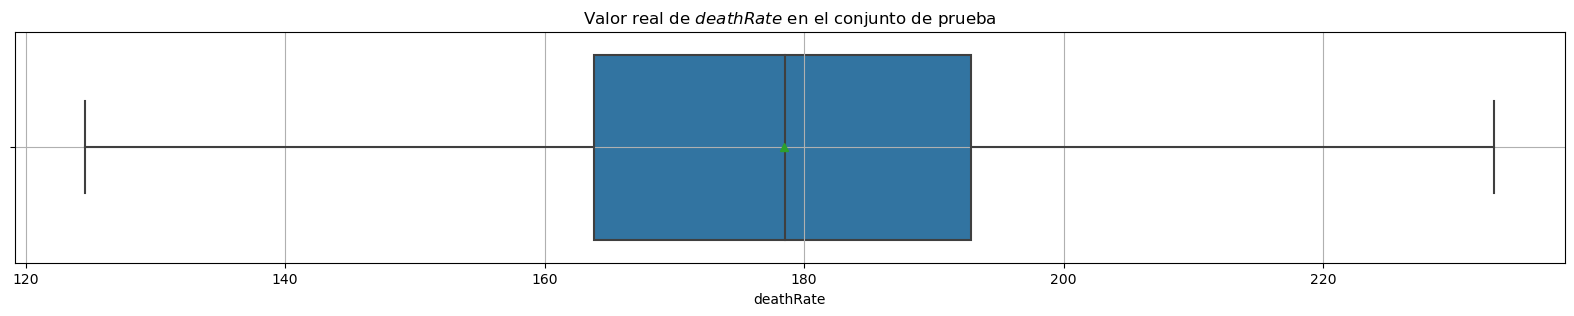

In [100]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_train, showmeans=True, orient="h")
plt.title("Valor real de $\t{deathRate}$ en el conjunto de prueba")
plt.grid()
plt.show()

In [101]:
y_train.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count    1492.000000
mean      178.449698
std        21.871320
min       124.600000
25%       163.800000
50%       178.550000
75%       192.875000
99%       228.454000
max       233.200000
Name: deathRate, dtype: float64

In [102]:
abs(y_train-regression.predict(X_train)).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count    1492.000000
mean       13.926256
std        11.195644
min         0.018815
25%         5.342021
50%        11.217015
75%        19.956522
95%        35.677316
99%        47.684717
max        76.209184
Name: deathRate, dtype: float64

Se podría decir que los resultados de este primer modelo están algo bien dado que para el conjunto de prueba los valores de la variable objetivo están centrados en $14.68 \pm 13.34$, mientras que el 50% de los errores de estimación del modelo se encuentran por debajo de 11.56, por debajo de una desviación estándar. Teniendo en cuenta que la media del deathRate es de 179 con una desviación de 27, entonces, el error esta en aproximadamente un 10% del valor real.

##### **9. Implementación del pipeline con todas las transformaciones requeridas para la generación de predicciones**

El objetivo de crear un pipeline es automatizar todos los
pasos realizados sobre los datos, desde que salen de su fuente hasta que son ingresados al modelo de aprendizaje automático. En este caso, la unica tranformación que encontramos en la preparación de los datos de esas variables que utilizamos fue la remocion de outliers.

In [54]:
"""
Para crear el pileline se tendra en cuenta el siguiente orden de transformacion de los datos:

1. Convertir valores de rangos de la columna binnedInc al promedio del rango

def average_range(range_str):
    # Verifica si range_str es una cadena de texto
    if isinstance(range_str, str):
        # Elimina los paréntesis o corchetes
        range_str = range_str.replace('(', '').replace(')', '').replace('[', '').replace(']', '')
        # Extrae los límites del rango
        lower, upper = map(float, range_str.split(','))
        # Calcula y devuelve el promedio del rango
        return (lower + upper) / 2
    else:
        # Si range_str no es una cadena de texto, devuelve el valor tal cual
        return range_str

# Aplica la función a la columna 'binnedInc'
train_data['binnedInc'] = train_data['binnedInc'].apply(average_range)

2. Remover outliers con el metodo IQR en todas las columnas numericas tipo float64 o int64

# Antes: deteccion de outliers, se hara por medio de la eleccion de cualquier tupla que tenga como valor en balance mayor a n la desviacion estandar de la columna balance. En este caso n = 2.

# Reemplazaremos los valores no consistentes por la mediana de la columna

# Deteccion de outliers
cols_to_check = features
n = 2

for col in cols_to_check:
    mean = train_data[col].mean()
    std = train_data[col].std()
    
    # Replace outliers with the median value
    train_data.loc[train_data[col] > (mean + n * std), col] = train_data[col].median()
    train_data.loc[train_data[col] < (mean - n * std), col] = train_data[col].median()

3. Reemplazar con la mediana a los valores tipo float de la columna "avgAnnCount"

# Calcula la mediana de la columna "avgAnnCount"
median = round(train_data['avgAnnCount'].median())

# Obtiene los valores únicos en la columna "avgAnnCount"
bag = train_data["avgAnnCount"].unique()

# Inicializa una lista vacía para almacenar los valores de tipo float
floats = []

# Itera sobre los valores únicos
for val in bag:
    # Comprueba si el valor es de tipo float
    decimal, integer = math.modf(val)
    if abs(decimal) > 0: 
        floats.append(val)

# Reemplaza los valores de tipo float en la columna "avgAnnCount" con la mediana
for float_val in floats:
    train_data['avgAnnCount'] = train_data['avgAnnCount'].replace(float_val, median)

4. Se hara la normalizacion de las columnas (PctWhite, PctBlack, PctAsian, PctOtherRace): se dividira cada valor de cada columna sobre la suma de las 4 columnas, de manera que la suma de los nuevos valores nos den una suma de 100 (en escala de 0 a 100)

# Define las columnas a normalizar
columns_to_normalize = ["PctWhite", "PctBlack", "PctAsian", "PctOtherRace"]

# Normaliza las columnas dividiendo cada valor por la suma de las columnas correspondientes y multiplicando por 100
for col in columns_to_normalize:
    train_data[col] = train_data[col] / row_sums_before * 100
    
5. Reemplazar los valores de la columna MedianAge con valores mayores a 122 con la mediana de la columna

# Calcula la mediana de la columna "MedianAge"
median = train_data['MedianAge'].median()

# Reemplaza los valores mayores a 122 en la columna "MedianAge" con la mediana
train_data.loc[train_data['MedianAge'] > 122, 'MedianAge'] = median

6. Eliminar columna PctSomeCol18_24 de los datos

train_data = train_data.drop(columns=['PctSomeCol18_24'])
"""

# Funciones de limpieza

class Clanning1(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convertir valores de rangos de la columna binnedInc al promedio del rango
        def average_range(range_str):
            # Verifica si range_str es una cadena de texto
            if isinstance(range_str, str):
                # Elimina los paréntesis o corchetes
                range_str = range_str.replace('(', '').replace(')', '').replace('[', '').replace(']', '')
                # Extrae los límites del rango
                lower, upper = map(float, range_str.split(','))
                # Calcula y devuelve el promedio del rango
                return (lower + upper) / 2
            else:
                # Si range_str no es una cadena de texto, devuelve el valor tal cual
                return range_str

        # Aplica la función a la columna 'binnedInc'
        X['binnedInc'] = X['binnedInc'].apply(average_range)

        return X
    
class Clanning2(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Deteccion de outliers, se hara por medio de la eleccion de cualquier tupla que tenga como valor en balance mayor a n la desviacion estandar de la columna balance. En este caso n = 2.

        # Reemplazaremos los valores no consistentes por la mediana de la columna

        # Deteccion de outliers
        cols_to_check = X.columns
        n = 2

        for col in cols_to_check:
            mean = X[col].mean()
            std = X[col].std()

            # Replace outliers with the median value
            X.loc[X[col] > (mean + n * std), col] = X[col].median()
            X.loc[X[col] < (mean - n * std), col] = X[col].median()

        return X
    
class Clanning3(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Calcula la mediana de la columna "avgAnnCount"
        median = round(X['avgAnnCount'].median())

        # Obtiene los valores únicos en la columna "avgAnnCount"
        bag = X["avgAnnCount"].unique()

        # Inicializa una lista vacía para almacenar los valores de tipo float
        floats = []

        # Itera sobre los valores únicos
        for val in bag:
            # Comprueba si el valor es de tipo float
            decimal, integer = math.modf(val)
            if abs(decimal) > 0: 
                floats.append(val)

        # Reemplaza los valores de tipo float en la columna "avgAnnCount" con la mediana
        for float_val in floats:
            X['avgAnnCount'] = X['avgAnnCount'].replace(float_val, median)

        return X
    
class Clanning4(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Define las columnas a normalizar
        columns_to_normalize = ["PctWhite", "PctBlack", "PctAsian", "PctOtherRace"]
        
        # Calcula la suma de las columnas a normalizar para cada fila antes de la normalización
        row_sums_before = X[columns_to_normalize].sum(axis=1)
        
        # Normaliza las columnas dividiendo cada valor por la suma de las columnas correspondientes y multiplicando por 100
        for col in columns_to_normalize:
            X[col] = X[col] / row_sums_before * 100
            
        return X
    
class Clanning5(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Calcula la mediana de la columna "MedianAge"
        median = X['MedianAge'].median()

        # Reemplaza los valores mayores a 122 en la columna "MedianAge" con la mediana
        X.loc[X['MedianAge'] > 122, 'MedianAge'] = median

        return X
    
class Clanning6(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Eliminar columna PctSomeCol18_24 de los datos
        X = X.drop(columns=['PctSomeCol18_24'])
        
        return X

# Crear un pipeline
pipeline = Pipeline([
    ("clanning1", Clanning1()),
    ("clanning2", Clanning2()),
    ("clanning3", Clanning3()),
    ("clanning4", Clanning4()),
    ("clanning5", Clanning5()),
    ("clanning6", Clanning6()),
    ("model", LinearRegression())
])

# Aplicar el pipeline a los datos
train_data_cleaned = pipeline.fit_transform(train_data)

# Verificar los datos limpios
train_data_cleaned.head()



NameError: name 'BaseEstimator' is not defined

In [49]:
pipeline = Pipeline(
    [
        ("model", LinearRegression())
    ]
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('model', LinearRegression())])

In [50]:
pd.DataFrame({"columns": ['PctBachDeg25_Over', 'incidenceRate', 'PctHS25_Over', 'povertyPercent', 'PctPublicCoverageAlone', 'PctPrivateCoverage', 'PctUnemployed16_Over', 'PctHS18_24'], "coef": pipeline["model"].coef_})

columns      coef
0       PctBachDeg25_Over -0.379233
1           incidenceRate  0.159253
2            PctHS25_Over  0.638044
3          povertyPercent  0.350478
4  PctPublicCoverageAlone  0.381145
5      PctPrivateCoverage -0.256398
6    PctUnemployed16_Over  0.726350
7              PctHS18_24  0.228547

In [51]:
pipeline["model"].intercept_

79.11333908498614

In [52]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("\nR2:")
print("Train:", r2_score(y_train, regression.predict(X_train)))

MAE:
Train: 13.926255698773694

RMSE:
Train: 17.866142129457707

R2:
Train: 0.3322671359402001


**Exportación del modelo en formato .joblib y generación de predicciones en la validación**

In [53]:
filename = "model.joblib"
dump(pipeline, filename)
pipeline_loaded = load(filename)
validacion = pd.read_csv('data/val_data.csv')

features = ['PctBachDeg25_Over', 'incidenceRate', 'PctHS25_Over', 'povertyPercent', 'PctPublicCoverageAlone', 'PctPrivateCoverage', 'PctUnemployed16_Over', 'PctHS18_24']
validacion = validacion[features]

validacion['deathRate'] = pipeline_loaded.predict(validacion)
validacion.to_csv('datos_validacion_con_deathRate.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'data/val_data.csv'

##### **10. Exploración de los supuestos de la regresión a partir del mejor modelo**

**10.1 Colinealidad**

 En el contexto de un modelo de regresión lineal, el impacto de una alta correlación entre dos variables independientes (predictoras) depende de lo que estés intentando lograr y de las características específicas de tu modelo y tus datos. Este fenómeno es conocido como multicolinealidad.

<AxesSubplot:>

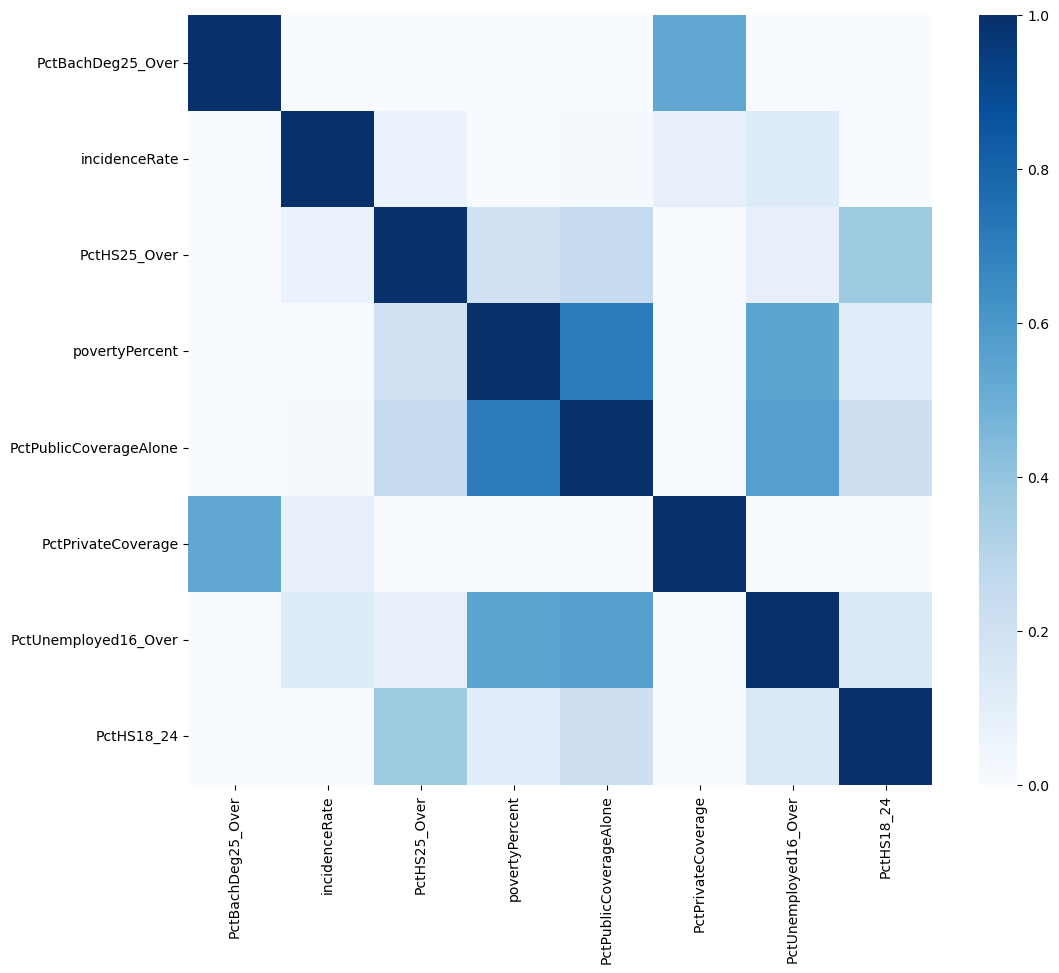

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

In [ ]:
X_train.corr()

PctBachDeg25_Over  incidenceRate  PctHS25_Over  \
PctBachDeg25_Over                1.000000      -0.000317     -0.599043   
incidenceRate                   -0.000317       1.000000      0.066030   
PctHS25_Over                    -0.599043       0.066030      1.000000   
povertyPercent                  -0.480269      -0.030122      0.203931   
PctPublicCoverageAlone          -0.503179       0.018689      0.252351   
PctPrivateCoverage               0.532307       0.084255     -0.181473   
PctUnemployed16_Over            -0.331128       0.132479      0.084943   
PctHS18_24                      -0.351191       0.001893      0.375687   

                        povertyPercent  PctPublicCoverageAlone  \
PctBachDeg25_Over            -0.480269               -0.503179   
incidenceRate                -0.030122                0.018689   
PctHS25_Over                  0.203931                0.252351   
povertyPercent                1.000000                0.712302   
PctPublicCoverageAlone        0.712302                1.000000   
PctPrivateCoverage           -0.739931               -0.813801   
PctUnemployed16_Over          0.539667                0.568183   
PctHS18_24                    0.113155                0.217062   

                        PctPrivateCoverage  PctUnemployed16_Over  PctHS18_24  
PctBachDeg25_Over                 0.532307             -0.331128   -0.351191  
incidenceRate                     0.084255              0.132479    0.001893  
PctHS25_Over                     -0.181473              0.084943    0.375687  
povertyPercent                   -0.739931              0.539667    0.113155  
PctPublicCoverageAlone           -0.813801              0.568183    0.217062  
PctPrivateCoverage                1.000000             -0.533234   -0.232654  
PctUnemployed16_Over             -0.533234              1.000000    0.142334  
PctHS18_24                       -0.232654              0.142334    1.000000

Se ve que la colinealidad no supero el 90% por lo que se considera no eliminar columnas, esto concluye que para este aspecto no se necesita una transformación

**10.2 Linealidad**

Se debe comprobar que la relación entre la variable de entrada y de salida sea lineal

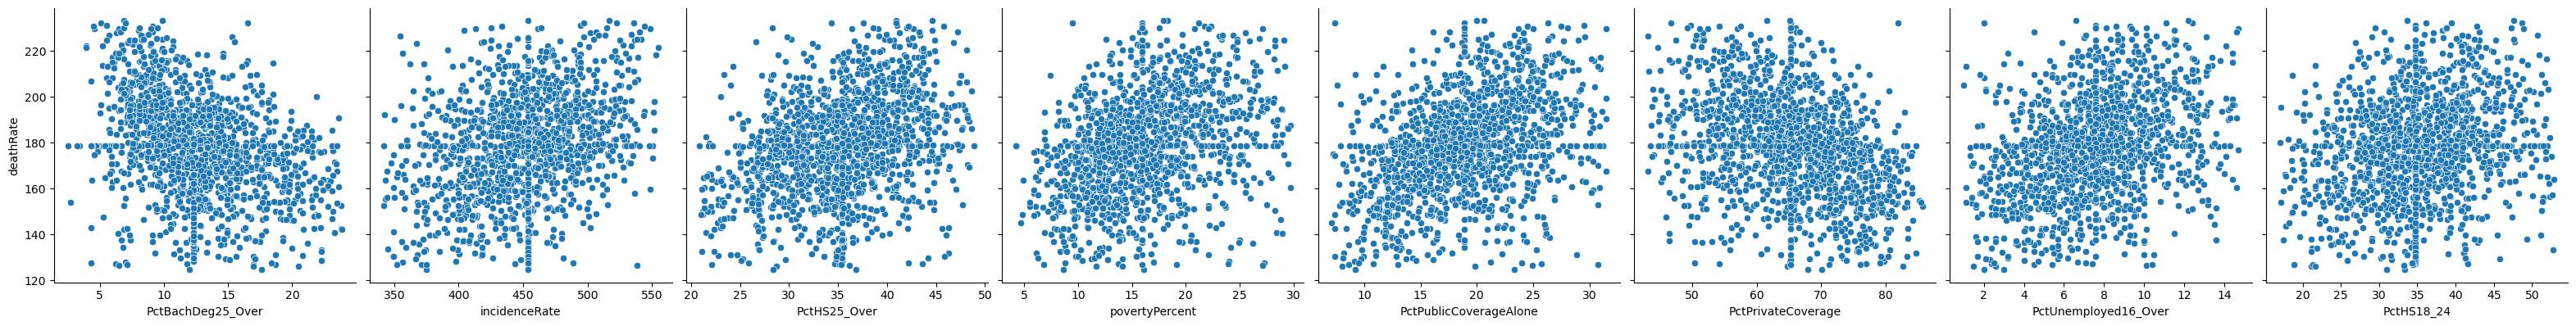

In [ ]:
yvar = "deathRate"
sns.pairplot(pd.concat([X_train, y_train], axis=1), height=4, y_vars=yvar, x_vars=features, kind="scatter")

**10.3 Normalidad de los errores**

Los errores deben seguir una distribución normal

In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [ ]:
pipeline.fit(X_train[features], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [ ]:
errors = (pipeline.predict(X_train[features])-y_train).values

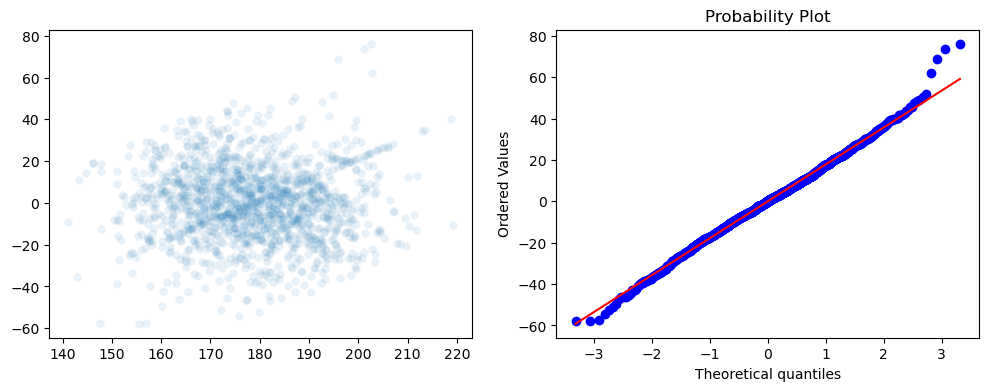

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Dispersión
sns.scatterplot(x=pipeline.predict(X_train[features]), y=errors, alpha=0.1, ax=axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

Vemos que los errores siguen una distribución normal muy buena por la gráfica presentada anteriormente, lo que nos concluye que no es necesario hacer transformaciones y que el modelo es linealmente muy bueno

**10.4 Varianza constante (Homeocedasticidad)**

La varianza en los errores debe mantenerse constante a medida que varia la variable objetivo.

<AxesSubplot:>

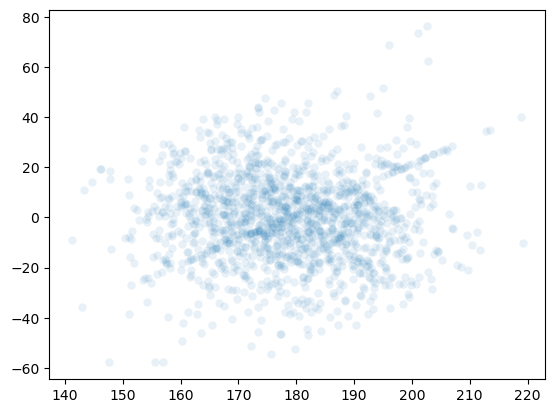

In [ ]:
sns.scatterplot(x = pipeline.predict(X_train[features]), y=errors, alpha=0.1)

Viendo la Homeocedasticidad del modelo se puede ver qye es decente y se podría mejorar aplicando nuevamente transformaciones no lineales sobre las variables de entrada. Por otro lado, también puede indicar que hacen falta variables de entrada que ayuden a representar apropiadamente la variable objetivo.

##### **12. Interpretación de los coeficientes del modelo**

In [ ]:
pd.DataFrame({"columns": features, "coef": regression.coef_})

columns      coef
0       PctBachDeg25_Over -0.379233
1           incidenceRate  0.159253
2            PctHS25_Over  0.638044
3          povertyPercent  0.350478
4  PctPublicCoverageAlone  0.381145
5      PctPrivateCoverage -0.256398
6    PctUnemployed16_Over  0.726350
7              PctHS18_24  0.228547

In [ ]:
regression.intercept_

79.11333908498622

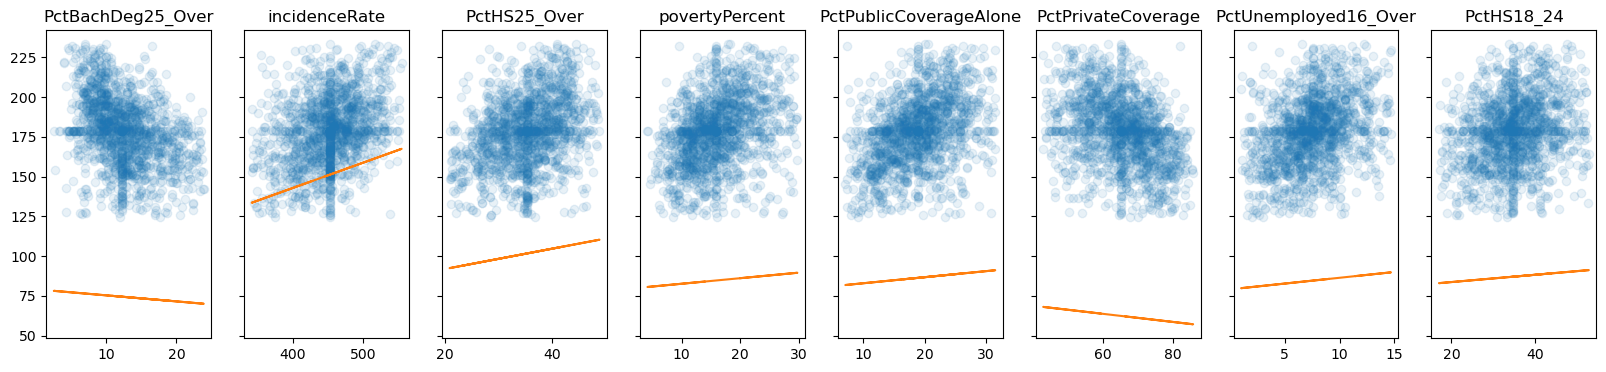

In [ ]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

Se puede ver que para la primera variable tiene una pendiente negativa por lo que mientras esta sube el deathRate disminuye, con respecto a las demás variables la pendiente es positiva y no es muy alta, excepto para el incidenceRate que vemos que es muy significativa.